In [1]:

# sphinx_gallery_thumbnail_number = 2

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import pywt
import mne_nirs
import mne



# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
    
)

# Import MNE processing
from mne.viz import plot_compare_evokeds

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import (enhance_negative_correlation, short_channel_regression)
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from collections import defaultdict
import numpy as np
from itertools import compress
from sklearn.decomposition import PCA

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm, statsmodels_to_results
from nilearn.plotting import plot_design_matrix
from mne.annotations import Annotations
from statsmodels.formula.api import mixedlm


from scipy.stats import ttest_ind


# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


# import summary_df from csv file
summary_df = pd.read_csv("global_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore.csv")
#stats_df = pd.read_csv("individual_mean_stddev_zscore_nocrop.csv")
stats_df = pd.read_csv("individual_mean_stddev_zscore_negcorr.csv")


# Preprocessing

## Epoch rejection

In [2]:
def reject_epochs(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0):
    """
    Rejects epochs based on z-score threshold using subject/session/condition-specific stats from stats_df.

    Parameters:
        data (ndarray): (n_epochs,) or (n_epochs, n_times) – mean amplitude per epoch
        subject (str): e.g., "01"
        session (str): e.g., "01"
        condition_name (str): "Control", "Noise", or "Speech"
        stats_df (pd.DataFrame): DataFrame with per-participant mean and std
        z_thresh (float): Z-score threshold
        max_reject_ratio (float): Max proportion of epochs to reject

    Returns:
        cleaned_data (ndarray), {
            "CONDITION_GOOD_IDX": [...],
            "CONDITION_BAD_IDX": [...]
        }
    """

    # Extract stats
    row = stats_df[
        (stats_df["Subject"] == f"sub-{subject}") &
        (stats_df["Session"] == f"ses-{session}") &
        (stats_df["Condition"] == condition_name)
    ]

    if row.empty:
        raise ValueError(f"No stats found for sub-{subject}, ses-{session}, {condition_name}")

    mean_val = row["Mean_Amplitude"].values[0]
    std_val = row["SD_Amplitude"].values[0]

    # Ensure data is 1D
    if data.ndim > 1:
        data = data.mean(axis=1)

    # Compute z-scores and rejection mask
    z_scores = (data - mean_val) / std_val
    reject_mask = np.abs(z_scores) > z_thresh
    rejected_indices = np.where(reject_mask)[0].tolist()

    # Enforce max rejection ratio
    max_allowed = int(max_reject_ratio * data.shape[0])
    if len(rejected_indices) > max_allowed:
        rejected_indices = rejected_indices[:max_allowed]

    # Determine kept indices
    all_indices = set(range(data.shape[0]))
    good_indices = sorted(list(all_indices - set(rejected_indices)))
    bad_indices = sorted(rejected_indices)

    # Clean the data
    cleaned_data = np.delete(data, rejected_indices, axis=0)

    # Construct keys
    condition_upper = condition_name.upper()
    good_key = f"{condition_upper}_GOOD_IDX"
    bad_key = f"{condition_upper}_BAD_IDX"

    return cleaned_data, {
        good_key: good_indices,
        bad_key: bad_indices
    }


## Full preprocessing + GLM

In [3]:
# cropping the signal before sci calculation
def preprocessing_glm_ROI(bids_path, subject_id, session_id, id, apply_epoch_rejection=True):
    print(f"Processing subject {subject_id} session {session_id}...")
    # Read data with annotations in BIDS format
    raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity.annotations.set_durations({'Control' : 5, 'Noise' : 5, 'Speech' : 5.25})
    
    # Get the events locations
    Breaks, _ = mne.events_from_annotations(raw_intensity, {'Xstart': 4, 'Xend': 5})
    AllEvents, _ = mne.events_from_annotations(raw_intensity)
    ControlEvents, _ = mne.events_from_annotations(raw_intensity, {'Control': 1})
    NoiseEvents, _ = mne.events_from_annotations(raw_intensity, {'Noise': 2})
    SpeechEvents, _ = mne.events_from_annotations(raw_intensity, {'Speech': 3})
    Breaks = Breaks[:, 0] / raw_intensity.info['sfreq']
    LastEvent = AllEvents[-1, 0] / raw_intensity.info['sfreq']

    if len(Breaks) % 2 == 0:
        raise ValueError("Breaks array should have an odd number of elements.")

    original_duration = raw_intensity.times[-1] - raw_intensity.times[0]

    # Cropping dataset
    cropped_intensity = raw_intensity.copy().crop(Breaks[0], Breaks[1])
    for j in range(2, len(Breaks) - 1, 2):
        block = raw_intensity.copy().crop(Breaks[j], Breaks[j + 1])
        cropped_intensity.append(block)
    cropped_intensity.append(raw_intensity.copy().crop(Breaks[-1], LastEvent + 15.25))

    cropped_duration = cropped_intensity.times[-1] - cropped_intensity.times[0]
    if cropped_duration >= original_duration:
        print(f"WARNING: Cropping did not reduce duration!")

    raw_intensity_cropped = cropped_intensity.copy()

    # Remove break annotations
    raw_intensity.annotations.delete(np.where(
        (raw_intensity.annotations.description == 'Xstart') | 
        (raw_intensity.annotations.description == 'Xend') | 
        (raw_intensity.annotations.description == 'BAD boundary') | 
        (raw_intensity.annotations.description == 'EDGE boundary')
    )[0])

    raw_intensity_cropped.annotations.delete(np.where(
        (raw_intensity_cropped.annotations.description == 'Xstart') | 
        (raw_intensity_cropped.annotations.description == 'Xend') | 
        (raw_intensity_cropped.annotations.description == 'BAD boundary') | 
        (raw_intensity_cropped.annotations.description == 'EDGE boundary')
    )[0]) 

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    raw_od_cropped = optical_density(raw_intensity_cropped)

    # get the total number of short channels
    short_chs = get_short_channels(raw_od)
    tot_number_of_short_channels = len(short_chs.ch_names)

    # sci calculated
    sci = scalp_coupling_index(raw_od_cropped, l_freq=0.7, h_freq=1.45)
    bad_channels= list(compress(raw_od.ch_names, sci < 0.8))

    if len(bad_channels) > 55:
        print(f"❌ Too many bad channels ({len(bad_channels)}). Excluding subject from analysis.")
        return None

    raw_od.info["bads"] = bad_channels
    raw_intensity_cropped.info["bads"] = bad_channels

    raw_od = temporal_derivative_distribution_repair(raw_od)
    raw_od_cropped = temporal_derivative_distribution_repair(raw_od_cropped)

    # Get long channels
    long_chs = get_long_channels(raw_od)
    bad_long_chs = long_chs.info["bads"]

    len_bad_short_chs = len(bad_channels) - len(bad_long_chs)
    num_good_short_channels = tot_number_of_short_channels - len_bad_short_chs

    if num_good_short_channels < 4:
        print("❌ No short channels found. Skipping the subject.")
        return None, None, None, None, None
    else:
        # lets not include the short channels in the raw_od
        raw_od_corrected = short_channel_regression(raw_od)
        
        # raw_od_corrected = raw_od.copy()


    # Convert to haemoglobin and filter
    raw_haemo_bef = beer_lambert_law(raw_od_corrected, ppf=0.1)
    raw_haemo_bef = get_long_channels(raw_haemo_bef, min_dist=0.02)
    
    # negative correlation enhancement
    raw_haemo_bef = enhance_negative_correlation(raw_haemo_bef)

    
     
    raw_haemo_bef = raw_haemo_bef.filter(l_freq=None, h_freq=0.2, method="iir", iir_params=dict(order=5, ftype='butter'))
    raw_haemo_bef = raw_haemo_bef.filter(l_freq=0.05, h_freq=None, method="iir", iir_params=dict(order=5, ftype='butter'))
    
    
    # EPOCH REJECTION
    if apply_epoch_rejection:
        all_events, all_event_dict = mne.events_from_annotations(raw_haemo_bef)
        epochs = mne.Epochs(
            raw_haemo_bef,
            all_events,
            event_id=all_event_dict,
            tmin=-3,
            tmax=14,
            reject=dict(hbo=100e-6),
            reject_by_annotation=True,
            proj=True,
            baseline=(None, 0),
            detrend=1,
            preload=True,
            verbose=None,
        )
        
        """ evoked_dict = {
            "Noise/HbO": epochs["Noise"].average(picks="hbo"),
            "Noise/HbR": epochs["Noise"].average(picks="hbr"),
            "Speech/HbO": epochs["Speech"].average(picks="hbo"),
            "Speech/HbR": epochs["Speech"].average(picks="hbr"),
            "Control/HbO": epochs["Control"].average(picks="hbo"),
            "Control/HbR": epochs["Control"].average(picks="hbr"),
        }

        # Rename channels until the encoding of frequency in ch_name is fixed
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4])

        color_dict = dict(HbO="#AA3377", HbR="b")
        styles_dict = dict(Control=dict(linestyle="dashed"), 
                           Noise=dict(linestyle="solid"),
                           Speech=dict(linestyle="dotted"))

        mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
        ) """

        bad_ch = epochs.info['bads']
        epochs.drop_channels(bad_ch)
        hbo_data = epochs.copy().pick("hbo")
        #data = hbo_data.get_data(tmin=0, tmax=10).mean(axis=1)
        data = hbo_data.get_data().mean(axis=1)
        
        ev = epochs.events[:, 2]
        index_column = np.arange(0, len(ev)).reshape(-1, 1)
        updated_matrix = np.hstack((index_column, ev.reshape(-1, 1)))

        #time_slice = data[:, :, 26:105]
        mean_values = np.mean(data, axis=1)
        

        control_idx = updated_matrix[updated_matrix[:, 1] == 1][:, 0]
        noise_idx = updated_matrix[updated_matrix[:, 1] == 2][:, 0]
        speech_idx = updated_matrix[updated_matrix[:, 1] == 3][:, 0]

        control_mean = mean_values[control_idx]
        noise_mean = mean_values[noise_idx]
        speech_mean = mean_values[speech_idx]

        
        #  reject_epochs(data, subject, session, condition_name, stats_df, z_thresh=3.0, max_reject_ratio=1.0)
        
        cleaned_data, idx_dict = reject_epochs(
            data=control_mean,
            subject=subject_id,
            session=session_id,
            condition_name="Control",
            stats_df=stats_df,
            z_thresh=2,
            max_reject_ratio=1
        )
       
        CONTROL_GOOD_IDX = idx_dict["CONTROL_GOOD_IDX"]
        CONTROL_BAD_IDX = idx_dict["CONTROL_BAD_IDX"]
        
        cleaned_data, idx_dict = reject_epochs(
            data=noise_mean,
            subject=subject_id,
            session=session_id,
            condition_name="Noise",
            stats_df=stats_df,
            z_thresh=2,
            max_reject_ratio=1
        )
        NOISE_GOOD_IDX = idx_dict["NOISE_GOOD_IDX"]
        NOISE_BAD_IDX = idx_dict["NOISE_BAD_IDX"]
        
        cleaned_data, idx_dict = reject_epochs(
            data=speech_mean,
            subject=subject_id,
            session=session_id,
            condition_name="Speech",
            stats_df=stats_df,
            z_thresh=2,
            max_reject_ratio=1
        )
        
        SPEECH_GOOD_IDX = idx_dict["SPEECH_GOOD_IDX"]
        SPEECH_BAD_IDX = idx_dict["SPEECH_BAD_IDX"]
        
        print(f"Number of rejected Control epochs: {len(CONTROL_BAD_IDX)}")
        print(f"Number of rejected Noise epochs: {len(NOISE_BAD_IDX)}")
        print(f"Number of rejected Speech epochs: {len(SPEECH_BAD_IDX)}")

        raw_haemo = raw_haemo_bef.copy()

        ControlEvents_good = ControlEvents[CONTROL_GOOD_IDX]
        onsets_control = raw_haemo.times[ControlEvents_good[:, 0]]
        durations_control = [0] * len(onsets_control)
        descriptions_control = ['Control'] * len(onsets_control)
        good_annotations_control = Annotations(onset=onsets_control, duration=durations_control, description=descriptions_control)

        NoiseEvents_good = NoiseEvents[NOISE_GOOD_IDX]
        onsets_noise = raw_haemo.times[NoiseEvents_good[:, 0]]
        durations_noise = [0] * len(onsets_noise)
        descriptions_noise = ['Noise'] * len(onsets_noise)
        good_annotations_noise = Annotations(onset=onsets_noise, duration=durations_noise, description=descriptions_noise)

        SpeechEvents_good = SpeechEvents[SPEECH_GOOD_IDX]
        onsets_speech = raw_haemo.times[SpeechEvents_good[:, 0]]
        durations_speech = [0] * len(onsets_speech)
        descriptions_speech = ['Speech'] * len(onsets_speech)
        good_annotations_speech = Annotations(onset=onsets_speech, duration=durations_speech, description=descriptions_speech)

        combined_annotations = good_annotations_control + good_annotations_noise + good_annotations_speech
        raw_haemo.set_annotations(combined_annotations)
    else:
        
        raw_haemo = raw_haemo_bef.copy()

    # make that raw_heamo only have hbo channels
    raw_haemo= raw_haemo.pick("hbo")
    events, event_dict = mne.events_from_annotations(raw_haemo)
    isis, names = mne_nirs.experimental_design.longest_inter_annotation_interval(raw_haemo)
    design_matrix = make_first_level_design_matrix(
        raw_haemo,
        drift_model='cosine',
        high_pass=1/(2*max(isis)),
        hrf_model='spm',
        stim_dur=5.125
    )
    
    
    
    
    glm_est = run_glm(raw_haemo, design_matrix)

      
    # Define ROI channel pairs
    left = [[4, 2], [4, 3], [5, 2], [5, 3], [5, 4], [5, 5]]
    right = [[10, 9], [10, 10], [10, 11], [10, 12], [11, 11], [11, 12]]
    back = [[6, 6], [6, 8], [7, 6], [7, 7], [7, 8], [8, 7], [8, 8], [9, 8]] 
    front = [[1, 1], [2, 1], [3, 1], [3, 2], [12, 1]]
    
    # Speech GLM: S11_D11, S11_D12, S7_D7, S4_D2, S9_D8, S4_D3
    speech_glm = [[11, 11], [11, 12], [7, 7], [4, 2], [9, 8], [4, 3]]

    # Noise GLM: S11_D12, S11_D11
    noise_glm = [[11, 12], [11, 11]]

    # Noise WAA: S10_D11, S10_D12, S11_D11, S11_D12, S10_D9, S6_D8, S4_D2
    noise_waa = [[10, 11], [10, 12], [11, 11], [11, 12], [10, 9], [6, 8], [4, 2]]

    # Speech WAA: S10_D11, S11_D12, S5_D4, S10_D9, S10_D10, S10_D12, S11_D11
    speech_waa = [[10, 11], [11, 12], [5, 4], [10, 9], [10, 10], [10, 12], [11, 11]]

    
   
    

    # Generate index picks for each ROI
    roi_picks = dict(
        Left= picks_pair_to_idx(raw_haemo, left, on_missing="ignore"),
        Right= picks_pair_to_idx(raw_haemo, right, on_missing="ignore"),
        Back= picks_pair_to_idx(raw_haemo, back, on_missing="ignore"),
        Front= picks_pair_to_idx(raw_haemo, front, on_missing="ignore"),
        
        Speech_glm= picks_pair_to_idx(raw_haemo, speech_glm, on_missing="ignore"),
        Noise_glm= picks_pair_to_idx(raw_haemo, noise_glm, on_missing="ignore"),
        Noise_waa= picks_pair_to_idx(raw_haemo, noise_waa, on_missing="ignore"),
        Speech_waa= picks_pair_to_idx(raw_haemo, speech_waa, on_missing="ignore"),  
        
          
    )
   
    
    cha= glm_est.to_dataframe()
    
    roi= glm_est.to_dataframe_region_of_interest(
        roi_picks, design_matrix.columns, demographic_info=True
    )
    
    # Define left vs right tapping contrast
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict(
        [(column, contrast_matrix[i]) for i, column in enumerate(design_matrix.columns)]
    )
    contrast_LvR_n = basic_conts["Noise"] - basic_conts["Control"]
    contrast_LvR_s = basic_conts["Speech"] - basic_conts["Control"]

    # Compute defined contrast
    contrast_n = glm_est.compute_contrast(contrast_LvR_n)
    contrast_s = glm_est.compute_contrast(contrast_LvR_s)
    con_n = contrast_n.to_dataframe()
    con_s = contrast_s.to_dataframe()

    # Add the participant sub to the dataframes
    roi["ID"] = cha["ID"] = con_n["ID"] = con_s["ID"] = id
    
    roi["Subject"] = cha["Subject"] = con_n["Subject"] = con_s["Subject"] = subject_id
    
    # Add the session to the dataframes
    roi["session"] = cha["session"] = con_n["session"] = con_s["session"] = session_id

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.0e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.0e6 for t in roi["theta"]]
    con_n["effect"] = [t * 1.0e6 for t in con_n["effect"]]
    con_s["effect"] = [t * 1.0e6 for t in con_s["effect"]]
    
    
    
    return raw_haemo, roi, cha, con_n, con_s
    

In [4]:

bids_root = r"C:\Datasets\Test-retest study\bids_dataset"
subject_list = sorted([d for d in os.listdir(bids_root) if d.startswith("sub-")])
subject_list = [s.replace("sub-", "") for s in subject_list]
#subject_list = subject_list[:1]  # Limit to first 3 subjects for testing

print("Detected subjects:", subject_list)
subjects_df = pd.DataFrame(columns=["subject", "session"])




#optode_subject_sessions = {optode: pd.DataFrame(columns=["subject", "session"]) for optode in optodes}

df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con_noise = pd.DataFrame()  # To store channel level contrast results
df_con_speech = pd.DataFrame()  # To store channel level contrast results
id = 0
# Loop through subjects and sessions
for sub in subject_list:
    for ses in range(1, 3):
        
        bids_path = BIDSPath(
                subject=f"{sub}",
                session=f"{ses:02d}",
                task="auditory",
                datatype="nirs",
                root=bids_root,
                suffix="nirs",
                extension=".snirf",
            )
            
        raw_haemo, roi, cha, con_n, con_s = preprocessing_glm_ROI(bids_path, sub, f"{ses:02d}", id, apply_epoch_rejection=True)
        if raw_haemo is None:
            print(f"⚠️ No data for Subject {sub}, Session {ses:02d}. Skipping...")
            continue
        else:
            
            # Append individual results to all participants
            df_roi = pd.concat([df_roi, roi], ignore_index=True)
            df_cha = pd.concat([df_cha, cha], ignore_index=True)
            df_con_noise = pd.concat([df_con_noise, con_n], ignore_index=True)
            df_con_speech = pd.concat([df_con_speech, con_s], ignore_index=True)
            id= id + 1
                
# add a column to df_cha with the channel names without the "hbo" or "hbr" suffix
df_cha["Optode"] = df_cha["ch_name"].str.replace(" hbo", "").str.replace(" hbr", "")


Detected subjects: ['01', '02', '03', '04', '05', '07', '08', '10', '11', '12', '13', '16', '17', '19', '21', '24']
Processing subject 01 session 01...
Number of rejected Control epochs: 1
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 1
Processing subject 01 session 02...
Number of rejected Control epochs: 2
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 1
Processing subject 02 session 01...
Number of rejected Control epochs: 1
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 02 session 02...
Number of rejected Control epochs: 1
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 03 session 01...
Number of rejected Control epochs: 0
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 03 session 02...
Number of rejected Control epochs: 0
Number of rejected Noise epochs: 1
Number of rejected Speech epochs: 0
Processing subject 0

# GLM Data-driven ROIs Construction
Single Optode Significance Analysis

## LME - Both ses

In [28]:
def run_lme_both_ses(df_cha):
    df_cha_q = df_cha.query("Condition in ['Control', 'Noise', 'Speech']")
    subset_session = df_cha_q[(df_cha_q["Chroma"] == "hbo")]
    optodes = subset_session["Optode"].unique()
    #print(optodes)
    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["ID"].nunique() < 2:
            print(f"Skipping {opt}  due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("theta ~ Condition", data=subset, groups=subset["ID"])
            result = model.fit(method="nm")
            #print(result.summary())

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["ID"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt}: {e}")

    return pd.DataFrame(results_summary)

def get_significant_optodes_by_condition(results_df):
    speech_sig = results_df[results_df["PValue_Condition[T.Speech]"] < 0.05].copy()
    noise_sig = results_df[results_df["PValue_Condition[T.Noise]"] < 0.05].copy()

    if speech_sig.empty:
        print("No significant SPEECH optodes.")
    if noise_sig.empty:
        print("No significant NOISE optodes.")

    return speech_sig, noise_sig

In [29]:
results_both_ses_df = run_lme_both_ses(df_cha)
speech_sig_both, noise_sig_both = get_significant_optodes_by_condition(results_both_ses_df)

c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## LME - Each Ses separately

In [30]:
def run_lme_per_session(df_cha, session_label):
    df_cha_q = df_cha.query("Condition in ['Control', 'Noise', 'Speech']")
    subset_session = df_cha_q[(df_cha_q["Chroma"] == "hbo") & (df_cha_q["session"] == session_label)]
    optodes = subset_session["Optode"].unique()
    #print(optodes)
    results_summary = []

    for opt in optodes:
        subset = subset_session[subset_session["Optode"] == opt]
        if subset["Condition"].nunique() < 2 or subset["Subject"].nunique() < 2:
            print(f"Skipping {opt} (Session {session_label}) due to insufficient data.")
            continue

        try:
            model = smf.mixedlm("theta ~ Condition", data=subset, groups=subset["Subject"])
            result = model.fit(method="nm")
            #print(result.summary())

            coef_s = result.params.get("Condition[T.Speech]", float('nan'))
            pval_s = result.pvalues.get("Condition[T.Speech]", float('nan'))

            coef_n = result.params.get("Condition[T.Noise]", float('nan'))
            pval_n = result.pvalues.get("Condition[T.Noise]", float('nan'))

            results_summary.append({
                "Optode": opt,
                "Coef_Condition[T.Noise]": coef_n,
                "PValue_Condition[T.Noise]": pval_n,
                "Coef_Condition[T.Speech]": coef_s,
                "PValue_Condition[T.Speech]": pval_s,
                "N_Subjects": subset["Subject"].nunique(),
                "N_Trials": len(subset),
                "Convergence": result.converged
            })

        except Exception as e:
            print(f"⚠️ Failed to fit model for {opt} (Session {session_label}): {e}")

    return pd.DataFrame(results_summary)


In [31]:
# Run LME per session
results_ses01_df = run_lme_per_session(df_cha, session_label='01')
results_ses02_df = run_lme_per_session(df_cha, session_label='02')


# Get significant optodes for each condition and session
speech_sig_ses01, noise_sig_ses01 = get_significant_optodes_by_condition(results_ses01_df)
speech_sig_ses02, noise_sig_ses02 = get_significant_optodes_by_condition(results_ses02_df)


c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sarab\anaconda3\envs\mne\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:223

## FDR correction

### Control vs Noise

In [35]:
m = 50  # number of independent tests
q = 0.05

# Get a copy of the DataFrame sorted by p-values
sorted_df = noise_sig_both.sort_values("PValue_Condition[T.Noise]").reset_index(drop=True)

# Loop through sorted rows
for i in range(len(sorted_df)):
    p_val = sorted_df.loc[i, "PValue_Condition[T.Noise]"]
    threshold = (q * (i + 1)) / m

    if p_val <= threshold:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is significant with p-value {p_val} and threshold {threshold}")
    else:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is not significant with p-value {p_val} and threshold {threshold}")


Optode S11_D12 is significant with p-value 0.0007505965812488266 and threshold 0.001
Optode S11_D11 is significant with p-value 0.0008984123204090398 and threshold 0.002
Optode S10_D11 is not significant with p-value 0.01187734533335958 and threshold 0.0030000000000000005


### Control vs Speech

In [18]:
m = 50  # number of independent tests
q = 0.05

# Get a copy of the DataFrame sorted by p-values
sorted_df = speech_sig_both.sort_values("PValue_Condition[T.Speech]").reset_index(drop=True)

# Loop through sorted rows
for i in range(len(sorted_df)):
    p_val = sorted_df.loc[i, "PValue_Condition[T.Speech]"]
    threshold = (q * (i + 1)) / m

    if p_val <= threshold:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is significant with p-value {p_val} and threshold {threshold}")
    else:
        print(f"Optode {sorted_df.loc[i, 'Optode']} is not significant with p-value {p_val} and threshold {threshold}")


Optode S11_D11 is significant with p-value 1.2152742751119441e-08 and threshold 0.001
Optode S11_D12 is significant with p-value 6.281653799195908e-07 and threshold 0.002
Optode S7_D7 is significant with p-value 2.0407881396981096e-05 and threshold 0.0030000000000000005
Optode S4_D2 is significant with p-value 2.4298052623448486e-05 and threshold 0.004
Optode S9_D8 is significant with p-value 0.0031657811730834984 and threshold 0.005
Optode S4_D3 is significant with p-value 0.0042037784367560905 and threshold 0.006000000000000001
Optode S8_D7 is not significant with p-value 0.007585231722474329 and threshold 0.007000000000000001
Optode S8_D8 is not significant with p-value 0.011300288867747987 and threshold 0.008
Optode S6_D8 is not significant with p-value 0.017990989125758965 and threshold 0.009000000000000001
Optode S10_D11 is not significant with p-value 0.029750477753003476 and threshold 0.01
Optode S5_D3 is not significant with p-value 0.049387212357824055 and threshold 0.0110000

# GLM Group-Level Analysis

## LME

In [19]:
grp_results = df_roi.query("Condition in ['Control','Noise', 'Speech']")

results_dict = {}

model_summary_df = pd.DataFrame(columns=["ROI", "Effect", "Coef", "StdErr", "z", "Pval", "CI_lower", "CI_upper"])


for roi in ["Left", "Right", "Back", "Front", "Noise_glm", "Speech_glm", "Noise_waa", "Speech_waa"]:
    print(f"Running mixed model for {roi}...")
    subset = grp_results[(grp_results["Chroma"] == "hbo") & (grp_results["ROI"] == roi)].copy()

    # Ensure categorical variables
    subset["Condition"] = subset["Condition"].astype("category")
    subset["session"] = subset["session"].astype("category")
    
    subset["Condition"] = subset["Condition"].cat.reorder_categories(["Control", "Noise", "Speech"], ordered=True)


    # Fit mixed model: Condition + Session as fixed, ID as random intercept
    model = smf.mixedlm("theta ~  Condition + session ", subset, groups=subset["Subject"])
    result = model.fit( method="nm")
    print(result.summary())
    
    results_dict[roi] = result
    
    # Extract desired coefficients
    for term in ["Condition[T.Noise]", "Condition[T.Speech]"]:
        if term in result.params:
            coef = result.params[term]
            stderr = result.bse[term]
            z_val = coef / stderr
            pval = result.pvalues[term]
            ci_low, ci_up = result.conf_int().loc[term]

            model_summary_df = pd.concat(
                [model_summary_df,
                    pd.DataFrame({
                        "ROI": [roi],
                        "Effect": [term],
                        "Coef": [coef],
                        "StdErr": [stderr],
                        "z": [z_val],
                        "Pval": [pval],
                        "CI_lower": [ci_low],
                        "CI_upper": [ci_up]
                    })],
                ignore_index=True
            )




Running mixed model for Left...
            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   theta    
No. Observations:    96        Method:               REML     
No. Groups:          16        Scale:                1.3797   
Min. group size:     6         Log-Likelihood:       -160.6538
Max. group size:     6         Converged:            Yes      
Mean group size:     6.0                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           -0.168    0.296 -0.568 0.570 -0.749  0.412
Condition[T.Noise]  -0.130    0.294 -0.444 0.657 -0.706  0.445
Condition[T.Speech]  0.553    0.294  1.884 0.060 -0.022  1.129
session[T.02]        0.432    0.240  1.800 0.072 -0.038  0.901
Group Var            0.486    0.243                           

Running mixed model for Right...
  

## FDR Correction

In [22]:
m = 16  # number of independent tests (e.g., 8 ROIs × 2 conditions)
q = 0.05

effects = model_summary_df["Effect"].unique()

for effect in effects:
    print(f"\n=== Analyzing Effect: {effect} ===")
    
    # Filter by effect
    df_effect = model_summary_df[model_summary_df["Effect"] == effect].copy()

    # Sort the DataFrame by p-value
    df_effect_sorted = df_effect.sort_values("Pval").reset_index(drop=True)

    # Apply FDR correction
    for i, row in df_effect_sorted.iterrows():
        p_val = row["Pval"]
        threshold = (q * (i + 1)) / m
        if p_val <= threshold:
            print(f"ROI {row['ROI']} is significant with p-value {p_val:.4f} and threshold {threshold:.4f}")
        else:
            print(f"ROI {row['ROI']} is not significant with p-value {p_val:.4f} and threshold {threshold:.4f}")



=== Analyzing Effect: Condition[T.Noise] ===
ROI Noise_glm is significant with p-value 0.0006 and threshold 0.0031
ROI Right is significant with p-value 0.0008 and threshold 0.0063
ROI Noise_waa is significant with p-value 0.0017 and threshold 0.0094
ROI Speech_waa is significant with p-value 0.0024 and threshold 0.0125
ROI Back is not significant with p-value 0.2525 and threshold 0.0156
ROI Front is not significant with p-value 0.3588 and threshold 0.0188
ROI Speech_glm is not significant with p-value 0.4810 and threshold 0.0219
ROI Left is not significant with p-value 0.6570 and threshold 0.0250

=== Analyzing Effect: Condition[T.Speech] ===
ROI Noise_glm is significant with p-value 0.0000 and threshold 0.0031
ROI Back is significant with p-value 0.0000 and threshold 0.0063
ROI Noise_waa is significant with p-value 0.0005 and threshold 0.0094
ROI Speech_glm is significant with p-value 0.0034 and threshold 0.0125
ROI Right is significant with p-value 0.0061 and threshold 0.0156
ROI S

## Rquantity and Roverlap

### Control vs Noise

In [25]:
sig_ses1 = set(noise_sig_ses01['Optode'])
sig_ses2 = set(noise_sig_ses02['Optode'])

A1 = len(sig_ses1)
A2 = len(sig_ses2)
A_overlap = len(sig_ses1 & sig_ses2)

R_quantity = 1 - (abs(A1 - A2) / (A1 + A2)) if (A1 + A2) > 0 else float('nan')
R_overlap = (2 * A_overlap) / (A1 + A2) if (A1 + A2) > 0 else float('nan')

print(f"Session 01: {A1} significant channels")
print(f"Session 02: {A2} significant channels")
print(f"Overlap   : {A_overlap} channels")
print(f"R_quantity: {R_quantity:.2f}")
print(f"R_overlap : {R_overlap:.2f}")

Session 01: 3 significant channels
Session 02: 3 significant channels
Overlap   : 2 channels
R_quantity: 1.00
R_overlap : 0.67


### Control vs Speech

In [26]:
sig_ses1 = set(speech_sig_ses01['Optode'])
sig_ses2 = set(speech_sig_ses02['Optode'])

A1 = len(sig_ses1)
A2 = len(sig_ses2)
A_overlap = len(sig_ses1 & sig_ses2)

R_quantity = 1 - (abs(A1 - A2) / (A1 + A2)) if (A1 + A2) > 0 else float('nan')
R_overlap = (2 * A_overlap) / (A1 + A2) if (A1 + A2) > 0 else float('nan')

print(f"Session 01: {A1} significant channels")
print(f"Session 02: {A2} significant channels")
print(f"Overlap   : {A_overlap} channels")
print(f"R_quantity: {R_quantity:.2f}")
print(f"R_overlap : {R_overlap:.2f}")

Session 01: 7 significant channels
Session 02: 11 significant channels
Overlap   : 6 channels
R_quantity: 0.78
R_overlap : 0.67


# GLM Individual Level Analysis

## ROI level

### Threshold approach

In [58]:
# For the Individual Analysis of the GLM we are just going to go over df_roi and compare the thetha values for each condition on each ROI for each subject-session. 
# If the theta value in noise or speech is higher than the control, we will consider it significant.
def get_individual_significant_rois(df_roi):
    df_hbo = df_roi[df_roi["Chroma"] == "hbo"].copy()
    
    results = []

    grouped = df_hbo.groupby(["Subject", "session", "ROI"])

    for (subj, sess, roi), group in grouped:
        try:
            theta_control = group[group["Condition"] == "Control"]["theta"].values[0]
        except IndexError:
            continue  # Skip if Control condition is missing

        theta_noise = group[group["Condition"] == "Noise"]["theta"]
        theta_speech = group[group["Condition"] == "Speech"]["theta"]

        is_noise_significant = False
        is_speech_significant = False

        if not theta_noise.empty:
            is_noise_significant = theta_noise.values[0] > theta_control

        if not theta_speech.empty:
            is_speech_significant = theta_speech.values[0] > theta_control

        results.append({
            "Subject": subj,
            "Session": sess,
            "ROI": roi,
            "Significant_Noise": is_noise_significant,
            "Significant_Speech": is_speech_significant,
            "Theta_Control": theta_control,
            "Theta_Noise": theta_noise.values[0] if not theta_noise.empty else None,
            "Theta_Speech": theta_speech.values[0] if not theta_speech.empty else None,
            
        })

    return pd.DataFrame(results)


individual_roi_results = get_individual_significant_rois(df_roi)



## Channel-level

### FDR Correction

#### Control vs Noise

In [15]:
# Store significant optodes
significant_optodes_list_noise = []

m = 25  # number of independent tests
q = 0.05
unique_subjects = df_con_noise["Subject"].unique()
unique_sessions = df_con_noise["session"].unique()

for subject in unique_subjects:
    for ses in unique_sessions:
        print(f"Processing subject {subject}, session {ses}...")
        df_con_noise_single = df_con_noise[
            (df_con_noise["Subject"] == subject) & 
            (df_con_noise["session"] == ses)
        ].copy()

        if df_con_noise_single.empty:
            print(f"No data for subject {subject}, session {ses}. Skipping...")
            continue

        df_con_noise_single["p_value"] = pd.to_numeric(df_con_noise_single["p_value"], errors='coerce')
        df_con_noise_single = df_con_noise_single.dropna(subset=["p_value"])

        sorted_df = df_con_noise_single.sort_values("p_value").reset_index(drop=True)

        for i in range(len(sorted_df)):
            p_val = sorted_df.loc[i, "p_value"]
            threshold = (q * (i + 1)) / m
            ch_name = sorted_df.loc[i, "ch_name"]

            if p_val <= threshold:
                print(f"Optode {ch_name} is significant with p-value {p_val} and threshold {threshold}")
                significant_optodes_list_noise.append({
                    "Subject": subject,
                    "session": ses,
                    "ch_name": ch_name,
                    "p_value": p_val
                })
            

Processing subject 01, session 01...
Optode S10_D12 hbo is significant with p-value 0.00030384468732117084 and threshold 0.002
Processing subject 01, session 02...
Optode S2_D1 hbo is significant with p-value 6.235360348072903e-05 and threshold 0.002
Optode S11_D11 hbo is significant with p-value 0.0001795495422623879 and threshold 0.004
Processing subject 02, session 01...
Processing subject 02, session 02...
Optode S12_D1 hbo is significant with p-value 1.5157434386113668e-11 and threshold 0.002
Optode S5_D4 hbo is significant with p-value 7.853137857817496e-05 and threshold 0.004
Optode S3_D1 hbo is significant with p-value 0.00020977072637622031 and threshold 0.006000000000000001
Optode S2_D1 hbo is significant with p-value 0.001822615909956005 and threshold 0.008
Optode S5_D2 hbo is significant with p-value 0.006021933572560584 and threshold 0.01
Optode S9_D8 hbo is significant with p-value 0.009520890799841081 and threshold 0.012000000000000002
Optode S10_D10 hbo is significant w

#### Control vs Speech

In [16]:
# Store significant optodes
significant_optodes_list_speech = []

m = 25  # number of independent tests
q = 0.05
unique_subjects = df_con_speech["Subject"].unique()
unique_sessions = df_con_speech["session"].unique()

for subject in unique_subjects:
    for ses in unique_sessions:
        print(f"Processing subject {subject}, session {ses}...")
        df_con_speech_single = df_con_speech[
            (df_con_speech["Subject"] == subject) & 
            (df_con_speech["session"] == ses)
        ].copy()

        if df_con_speech_single.empty:
            print(f"No data for subject {subject}, session {ses}. Skipping...")
            continue

        df_con_speech_single["p_value"] = pd.to_numeric(df_con_speech_single["p_value"], errors='coerce')
        df_con_speech_single = df_con_speech_single.dropna(subset=["p_value"])

        sorted_df = df_con_speech_single.sort_values("p_value").reset_index(drop=True)

        for i in range(len(sorted_df)):
            p_val = sorted_df.loc[i, "p_value"]
            threshold = (q * (i + 1)) / m
            ch_name = sorted_df.loc[i, "ch_name"]

            if p_val <= threshold:
                print(f"Optode {ch_name} is significant with p-value {p_val} and threshold {threshold}")
                significant_optodes_list_speech.append({
                    "Subject": subject,
                    "session": ses,
                    "ch_name": ch_name,
                    "p_value": p_val
                })
            

Processing subject 01, session 01...
Optode S8_D7 hbo is significant with p-value 6.3597790603036075e-06 and threshold 0.002
Processing subject 01, session 02...
Optode S11_D11 hbo is significant with p-value 9.79206132573772e-10 and threshold 0.002
Optode S10_D11 hbo is significant with p-value 0.0012584450143033725 and threshold 0.004
Processing subject 02, session 01...
Optode S4_D3 hbo is significant with p-value 1.820782320461118e-13 and threshold 0.002
Optode S11_D12 hbo is significant with p-value 4.076884388982645e-08 and threshold 0.004
Optode S11_D11 hbo is significant with p-value 0.004421601298311863 and threshold 0.006000000000000001
Processing subject 02, session 02...
Optode S4_D3 hbo is significant with p-value 4.525837259788964e-12 and threshold 0.002
Optode S11_D11 hbo is significant with p-value 0.002877774736507889 and threshold 0.004
Processing subject 03, session 01...
Optode S11_D11 hbo is significant with p-value 0.0005925319437472172 and threshold 0.002
Process

#### Plot activation Counts

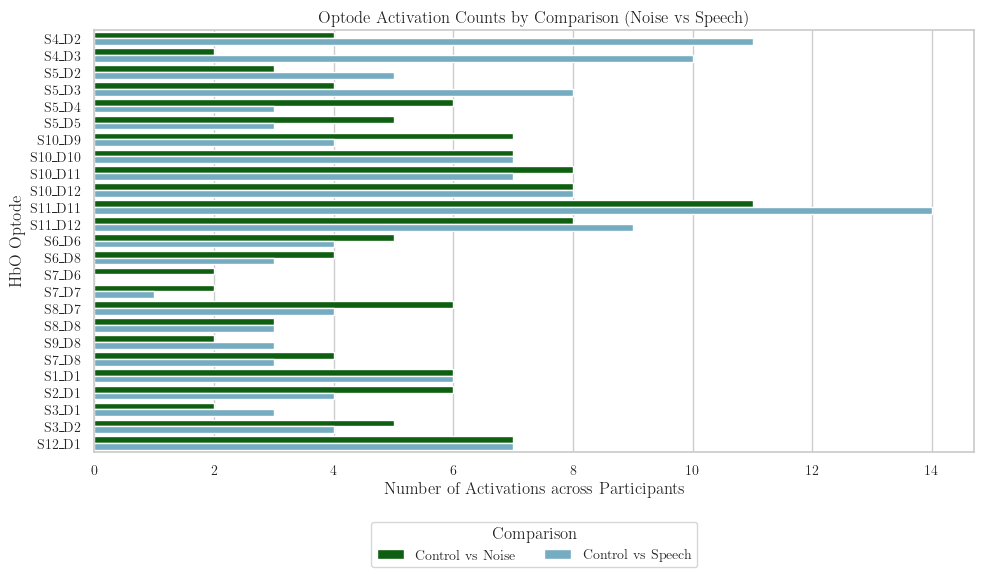

In [17]:
# --- Convert Noise list to DataFrame ---
df_sig_noise = pd.DataFrame(significant_optodes_list_noise)
df_sig_noise["ch_name"] = df_sig_noise["ch_name"].str.replace(" hbo", "", regex=False)

counts_noise = (
    df_sig_noise.groupby("ch_name")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_noise["Comparison"] = "Control vs Noise"
counts_noise.rename(columns={"ch_name": "ROI"}, inplace=True)

# --- Convert Speech list to DataFrame ---
df_sig_speech = pd.DataFrame(significant_optodes_list_speech)
df_sig_speech["ch_name"] = df_sig_speech["ch_name"].str.replace(" hbo", "", regex=False)

counts_speech = (
    df_sig_speech.groupby("ch_name")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_speech["Comparison"] = "Control vs Speech"
counts_speech.rename(columns={"ch_name": "ROI"}, inplace=True)

# --- Combine both DataFrames ---
roi_counts = pd.concat([counts_noise, counts_speech], ignore_index=True)

# --- Predefined Optode (ROI) Order ---
roi_order = [
    "S4_D2", "S4_D3", "S5_D2", "S5_D3", "S5_D4", "S5_D5",
    "S10_D9", "S10_D10", "S10_D11", "S10_D12", "S11_D11", "S11_D12",
    "S6_D6", "S6_D8", "S7_D6", "S7_D7", "S8_D7", "S8_D8",
    "S9_D8", "S7_D8", "S1_D1", "S2_D1", "S3_D1", "S3_D2", "S12_D1"
]

# --- Plotting ---
sns.set(style="whitegrid")

# Use two distinct colors for Noise and Speech
custom_palette = {
    "Control vs Noise": "#006D04",   # Green
    "Control vs Speech": "#69B1CE"   # Blue
}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=roi_counts,
    x="Count",
    y="ROI",
    hue="Comparison",
    order=roi_order,
    palette=custom_palette
)

plt.title("Optode Activation Counts by Comparison (Noise vs Speech)")
plt.xlabel("Number of Activations across Participants")
plt.ylabel("HbO Optode")
plt.legend(
    title="Comparison",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)
plt.tight_layout()
plt.show()


### Rquantity and Roverlap (with FDR correction)

In [ ]:
# Convert lists to DataFrames
df_sig_noise = pd.DataFrame(significant_optodes_list_noise)
df_sig_speech = pd.DataFrame(significant_optodes_list_speech)

# Ensure channel names are cleaned consistently
df_sig_noise["ch_name"] = df_sig_noise["ch_name"].str.replace(" hbo", "", regex=False)
df_sig_speech["ch_name"] = df_sig_speech["ch_name"].str.replace(" hbo", "", regex=False)

# Initialize result lists
results_noise = []
results_speech = []

# Get unique subjects from each condition
subjects_noise = df_sig_noise["Subject"].unique()
subjects_speech = df_sig_speech["Subject"].unique()

# Function to calculate R_quantity and R_overlap
def calculate_R_metrics(df, subject):
    df_subj = df[df["Subject"] == subject]
    sessions = df_subj["session"].unique()
    
    if len(sessions) < 2:
        return None  # Skip if fewer than two sessions

    ses1, ses2 = sessions[:2]  # Only compare the first two sessions
    
    ses1_channels = set(df_subj[df_subj["session"] == ses1]["ch_name"])
    ses2_channels = set(df_subj[df_subj["session"] == ses2]["ch_name"])

    A1 = len(ses1_channels)
    A2 = len(ses2_channels)
    A_overlap = len(ses1_channels.intersection(ses2_channels))

    if (A1 + A2) > 0:
        R_quantity = 1 - (abs(A1 - A2) / (A1 + A2))
        R_overlap = (2 * A_overlap) / (A1 + A2)
        
    else:
        R_quantity = 0
        R_overlap = 0
        
   

    return {
        "Subject": subject,
        "session1": ses1,
        "session2": ses2,
        "R_quantity": R_quantity,
        "R_overlap": R_overlap,
        
    }

# --- Noise ---
for subject in subjects_noise:
    res = calculate_R_metrics(df_sig_noise, subject)
    if res:
        res["Condition"] = "Noise"
        results_noise.append(res)

# --- Speech ---
for subject in subjects_speech:
    res = calculate_R_metrics(df_sig_speech, subject)
    if res:
        res["Condition"] = "Speech"
        results_speech.append(res)

# Combine results
df_rmetrics = pd.DataFrame(results_noise + results_speech)

# Optional: sort by subject and condition
df_rmetrics = df_rmetrics.sort_values(by=["Subject", "Condition"]).reset_index(drop=True)

# Display
print(df_rmetrics)


   Subject session1 session2  R_quantity  R_overlap Condition
0       01       01       02    0.666667   0.000000     Noise
1       01       01       02    0.666667   0.000000    Speech
2       02       01       02    0.800000   0.800000    Speech
3       04       01       02    0.857143   0.285714    Speech
4       05       01       02    0.720000   0.560000     Noise
5       05       01       02    0.571429   0.285714    Speech
6       07       01       02    0.666667   0.444444     Noise
7       07       01       02    0.769231   0.461538    Speech
8       08       01       02    0.909091   0.545455     Noise
9       08       01       02    0.666667   0.166667    Speech
10      10       01       02    0.272727   0.181818     Noise
11      10       01       02    0.333333   0.166667    Speech
12      11       01       02    0.400000   0.133333     Noise
13      11       01       02    1.000000   0.500000    Speech
14      12       01       02    1.000000   0.500000    Speech
15      

### Rquantity and Roverlap (without FDR correction)

#### Control vs Noise

In [35]:
# Filter for significant optodes only
df_sig = df_con_noise[df_con_noise["Significant"] == True]

# Get unique subjects
subjects = df_sig["Subject"].unique()

# For each subject, calculate R_overlap
for subj in sorted(subjects):
    # Filter data for the subject
    subj_data = df_sig[df_sig["Subject"] == subj]
   
    # Get channels for each session
    ses1_channels = set(subj_data[subj_data["session"] == "01"]["ch_name"])
    ses2_channels = set(subj_data[subj_data["session"] == "02"]["ch_name"])

    # Calculate activation quantities
    A1 = len(ses1_channels)
    A2 = len(ses2_channels)
    A_overlap = len(ses1_channels.intersection(ses2_channels))

    # Compute R_overlap safely (avoid division by zero)
    if (A1 + A2) > 0:
        R_quantity= 1- ((abs(A1 - A2) )/ (A1 + A2))
        R_overlap = (2 * A_overlap) / (A1 + A2)
    else:
        R_quantity = float('nan') 
        R_overlap = float('nan')

    print(f"Subject {subj}")
    print(f"  Session 01 significant channels ({A1}): {sorted(ses1_channels)}")
    print(f"  Session 02 significant channels ({A2}): {sorted(ses2_channels)}")
    print(f"  Overlapping channels ({A_overlap}): {sorted(ses1_channels.intersection(ses2_channels))}")
    print(f"  R_quantity: {R_quantity:.3f}")
    print(f"  R_overlap: {R_overlap:.3f}")
    
    print()



Subject 01
  Session 01 significant channels (2): ['S10_D12 hbo', 'S1_D1 hbo']
  Session 02 significant channels (3): ['S10_D11 hbo', 'S11_D11 hbo', 'S2_D1 hbo']
  Overlapping channels (0): []
  R_quantity: 0.800
  R_overlap: 0.000

Subject 02
  Session 01 significant channels (0): []
  Session 02 significant channels (10): ['S10_D10 hbo', 'S10_D11 hbo', 'S12_D1 hbo', 'S1_D1 hbo', 'S2_D1 hbo', 'S3_D1 hbo', 'S5_D2 hbo', 'S5_D4 hbo', 'S8_D8 hbo', 'S9_D8 hbo']
  Overlapping channels (0): []
  R_quantity: 0.000
  R_overlap: 0.000

Subject 03
  Session 01 significant channels (1): ['S11_D11 hbo']
  Session 02 significant channels (0): []
  Overlapping channels (0): []
  R_quantity: 0.000
  R_overlap: 0.000

Subject 04
  Session 01 significant channels (3): ['S10_D12 hbo', 'S11_D12 hbo', 'S6_D6 hbo']
  Session 02 significant channels (0): []
  Overlapping channels (0): []
  R_quantity: 0.000
  R_overlap: 0.000

Subject 05
  Session 01 significant channels (9): ['S10_D11 hbo', 'S10_D12 hbo', 

#### Control vs Speech

In [36]:
# Filter for significant optodes only
df_sig = df_con_speech[df_con_speech["Significant"] == True]

# Get unique subjects
subjects = df_sig["Subject"].unique()

# For each subject, calculate R_overlap
for subj in sorted(subjects):
    # Filter data for the subject
    subj_data = df_sig[df_sig["Subject"] == subj]
    
    
    # FDR
    
    # Get channels for each session
    ses1_channels = set(subj_data[subj_data["session"] == "01"]["ch_name"])
    ses2_channels = set(subj_data[subj_data["session"] == "02"]["ch_name"])
    
    

    # Calculate activation quantities
    A1 = len(ses1_channels)
    A2 = len(ses2_channels)
    A_overlap = len(ses1_channels.intersection(ses2_channels))

    # Compute R_overlap safely (avoid division by zero)
    if (A1 + A2) > 0:
        R_quantity= 1- ((abs(A1 - A2) )/ (A1 + A2))
        R_overlap = (2 * A_overlap) / (A1 + A2)
    else:
        R_quantity = float('nan') 
        R_overlap = float('nan')

    print(f"Subject {subj}")
    print(f"  Session 01 significant channels ({A1}): {sorted(ses1_channels)}")
    print(f"  Session 02 significant channels ({A2}): {sorted(ses2_channels)}")
    print(f"  Overlapping channels ({A_overlap}): {sorted(ses1_channels.intersection(ses2_channels))}")
    print(f"  R_quantity: {R_quantity:.3f}")
    print(f"  R_overlap: {R_overlap:.3f}")
    
    print()


Subject 01
  Session 01 significant channels (2): ['S1_D1 hbo', 'S8_D7 hbo']
  Session 02 significant channels (2): ['S10_D11 hbo', 'S11_D11 hbo']
  Overlapping channels (0): []
  R_quantity: 1.000
  R_overlap: 0.000

Subject 02
  Session 01 significant channels (5): ['S11_D11 hbo', 'S11_D12 hbo', 'S2_D1 hbo', 'S3_D1 hbo', 'S4_D3 hbo']
  Session 02 significant channels (2): ['S11_D11 hbo', 'S4_D3 hbo']
  Overlapping channels (2): ['S11_D11 hbo', 'S4_D3 hbo']
  R_quantity: 0.571
  R_overlap: 0.571

Subject 03
  Session 01 significant channels (2): ['S11_D11 hbo', 'S5_D2 hbo']
  Session 02 significant channels (0): []
  Overlapping channels (0): []
  R_quantity: 0.000
  R_overlap: 0.000

Subject 04
  Session 01 significant channels (5): ['S10_D12 hbo', 'S4_D3 hbo', 'S5_D2 hbo', 'S5_D3 hbo', 'S6_D6 hbo']
  Session 02 significant channels (3): ['S4_D2 hbo', 'S5_D3 hbo', 'S6_D6 hbo']
  Overlapping channels (2): ['S5_D3 hbo', 'S6_D6 hbo']
  R_quantity: 0.750
  R_overlap: 0.500

Subject 05
  

### Channel Activation Counts Figure

C:\Users\sarab\AppData\Local\Temp\ipykernel_22724\1569647233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_noise["ch_name"] = df_sig_noise["ch_name"].str.replace(" hbo", "", regex=False)
C:\Users\sarab\AppData\Local\Temp\ipykernel_22724\1569647233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_speech["ch_name"] = df_sig_speech["ch_name"].str.replace(" HbO", "", regex=False)


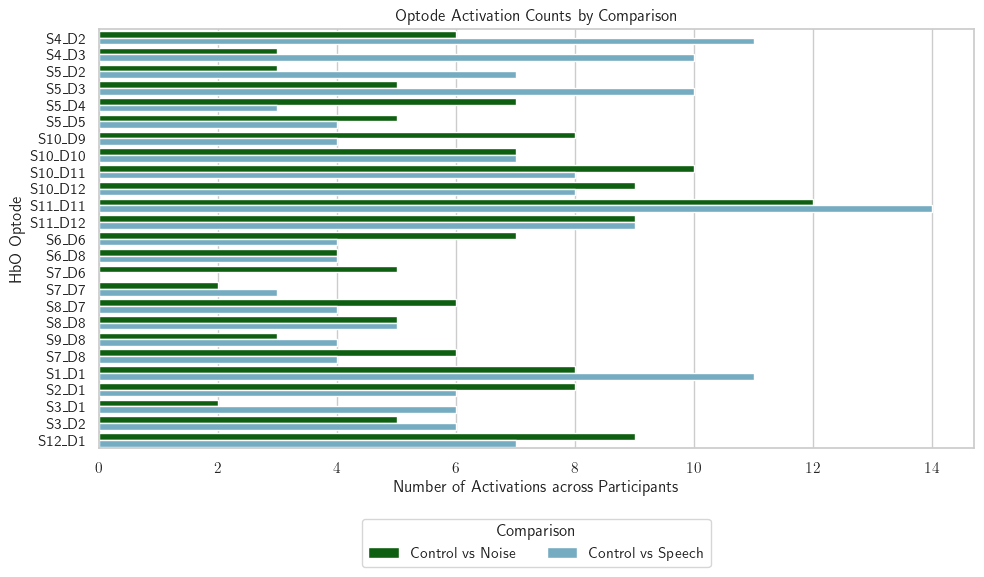

In [47]:
# For Noise
df_sig_noise = df_con_noise[df_con_noise["Significant"] == True]
df_sig_noise["ch_name"] = df_sig_noise["ch_name"].str.replace(" hbo", "", regex=False)
counts_noise = (
    df_sig_noise.groupby("ch_name")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_noise["Comparison"] = "Control vs Noise"

# For Speech
df_sig_speech = df_con_speech[df_con_speech["Significant"] == True]
df_sig_speech["ch_name"] = df_sig_speech["ch_name"].str.replace(" HbO", "", regex=False)
counts_speech = (
    df_sig_speech.groupby("ch_name")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_speech["Comparison"] = "Control vs Speech"

# Combine
roi_counts = pd.concat([counts_noise, counts_speech], ignore_index=True)
roi_counts.rename(columns={"ch_name": "ROI"}, inplace=True)

# --- Enable LaTeX-style text rendering ---
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})
# Filter for significant optodes and make a copy to avoid SettingWithCopyWarning
df_sig_noise = df_con_noise[df_con_noise["Significant"] == True].copy()
df_sig_noise["ch_name"] = df_sig_noise["ch_name"].str.replace(" hbo", "", regex=False)

df_sig_speech = df_con_speech[df_con_speech["Significant"] == True].copy()
df_sig_speech["ch_name"] = df_sig_speech["ch_name"].str.replace(" hbo", "", regex=False)


roi_order = [
    "S4_D2",
    "S4_D3",
    "S5_D2",
    "S5_D3",
    "S5_D4",
    "S5_D5",
    "S10_D9",
    "S10_D10",
    "S10_D11",
    "S10_D12",
    "S11_D11",
    "S11_D12",
    "S6_D6",
    "S6_D8",
    "S7_D6",
    "S7_D7",
    "S8_D7",
    "S8_D8",
    "S9_D8",
    "S7_D8",
    "S1_D1",
    "S2_D1",
    "S3_D1",
    "S3_D2",
    "S12_D1"
]


# Group by channel and count unique subjects (participants) for Noise
counts_noise = (
    df_sig_noise.groupby("ch_name")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_noise["Comparison"] = "Control vs Noise"

# Group by channel and count unique subjects for Speech
counts_speech = (
    df_sig_speech.groupby("ch_name")["Subject"]
    .nunique()
    .reset_index()
    .rename(columns={"Subject": "Count"})
)
counts_speech["Comparison"] = "Control vs Speech"

# Combine both counts into a single DataFrame
roi_counts = pd.concat([counts_noise, counts_speech], ignore_index=True)
roi_counts.rename(columns={"ch_name": "ROI"}, inplace=True)

# Plotting

# Set plot style
sns.set(style="whitegrid")

# Custom pastel but distinct colors: bright green and sky blue
custom_palette = {
    "Control vs Noise": "#006D04",  # soft green
    "Control vs Speech": "#69B1CE"  # soft blue
}

# Sort ROIs by total counts descending
""" roi_order = (
    roi_counts.groupby("ROI")["Count"]
    .sum()
    .sort_values(ascending=False)
    .index
)
 """
plt.figure(figsize=(10, 6))
sns.barplot(
    data=roi_counts,
    x="Count",
    y="ROI",
    hue="Comparison",
    order=roi_order,
    palette=custom_palette
)

plt.title("Optode Activation Counts by Comparison")
plt.xlabel("Number of Activations across Participants")
plt.ylabel("HbO Optode")
plt.legend(
    title="Comparison",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,  # Number of columns in the legend
    
)
plt.tight_layout()
plt.show()


# ICC(2,1)

## ROI

In [42]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
    "Noise_WAA": ["S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo", "S10_D9 hbo", "S6_D8 hbo", "S4_D2 hbo"],
    "Speech_WAA": ["S10_D11 hbo", "S11_D12 hbo", "S5_D4 hbo", "S10_D9 hbo", "S10_D10 hbo", "S10_D12 hbo", "S11_D11 hbo"],
    "Noise_GLM": ["S11_D12 hbo", "S11_D11 hbo"],
    "Speech_GLM": ["S11_D11 hbo", "S11_D12 hbo", "S7_D7 hbo", "S4_D2 hbo", "S9_D8 hbo", "S4_D3 hbo"],
    
    "Left_Auditory": ["S4_D2 hbo", "S4_D3 hbo", "S5_D2 hbo", "S5_D3 hbo", "S5_D4 hbo", "S5_D5 hbo"],
    "Right_Auditory": ["S10_D9 hbo", "S10_D10 hbo", "S10_D11 hbo", "S10_D12 hbo", "S11_D11 hbo", "S11_D12 hbo"],
    "Visual": ["S6_D6 hbo", "S6_D8 hbo", "S7_D6 hbo", "S7_D7 hbo","S8_D7 hbo", "S8_D8 hbo", "S9_D8 hbo", "S7_D8 hbo"],
    "Front": ["S1_D1 hbo", "S2_D1 hbo", "S3_D1 hbo", "S3_D2 hbo","S12_D1 hbo"] 
}
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "session", "Condition"])["theta"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "session": "raters",
        "theta": "scores"
    })
    

    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores")

    icc_2_1 = icc[icc["Type"] == "ICC2"].iloc[0]  # ICC(2,1)


    results_list.append({
        "ROI": roi_name,
        "ICC": icc_2_1["ICC"],
        "pval": icc_2_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: Noise_WAA
Processing ROI: Speech_WAA
Processing ROI: Noise_GLM
Processing ROI: Speech_GLM
Processing ROI: Left_Auditory
Processing ROI: Right_Auditory
Processing ROI: Visual
Processing ROI: Front
✅ ICC results saved to 'icc_results_combined_conditions.csv'


## Optodes

In [43]:
import pandas as pd
from pingouin import intraclass_corr

# --- Define ROIs (without ' hbo') ---
rois = {
            "S4_D2": ["S4_D2 hbo"],
            "S4_D3": ["S4_D3 hbo"],
            "S5_D2": ["S5_D2 hbo"],
            "S5_D3": ["S5_D3 hbo"],
            "S5_D4": ["S5_D4 hbo"],
            "S5_D5": ["S5_D5 hbo"],
            "S10_D9": ["S10_D9 hbo"],
            "S10_D10": ["S10_D10 hbo"],
            "S10_D11": ["S10_D11 hbo"],
            "S10_D12": ["S10_D12 hbo"],
            "S11_D11": ["S11_D11 hbo"],
            "S11_D12": ["S11_D12 hbo"],
            "S6_D6": ["S6_D6 hbo"],
            "S6_D8": ["S6_D8 hbo"],
            "S7_D6": ["S7_D6 hbo"],
            "S7_D7": ["S7_D7 hbo"],
            "S8_D7": ["S8_D7 hbo"],
            "S8_D8": ["S8_D8 hbo"],
            "S9_D8": ["S9_D8 hbo"],
            "S7_D8": ["S7_D8 hbo"],
            "S1_D1": ["S1_D1 hbo"],
            "S2_D1": ["S2_D1 hbo"],
            "S3_D1": ["S3_D1 hbo"],
            "S3_D2": ["S3_D2 hbo"],
            "S12_D1": ["S12_D1 hbo"],
        }
# --- Remove ' hbo' from optode names in ROIs ---
rois = {roi: [opt.replace(" hbo", "") for opt in optodes] for roi, optodes in rois.items()}



df_combined = pd.read_csv("all_subjects_evoked_values_optodes.csv")

# Filter for HbO only
df_combined = df_combined[df_combined["Chroma"] == "hbo"].copy()

# --- ICC computation ---
results_list = []

for roi_name, optodes in rois.items():
    print(f"Processing ROI: {roi_name}")
    
    # Filter for relevant optodes only
    subset = df_combined[df_combined["Optode"].isin(optodes)]

    # Mean over optodes per subject/session/condition (but do NOT average across conditions)
    mean_values = subset.groupby(["Subject", "session", "Condition"])["theta"].mean().reset_index()

    # Replicates for each Subject-Session (Condition = replicate)
    # ICC expects: targets (subjects), raters (sessions), ratings (values)
    icc_input = mean_values.rename(columns={
        "Subject": "targets",
        "session": "raters",
        "theta": "scores"
    })
    
    #print(icc_input.head())

    # ICC(3,1): Two-way mixed, single measurement, consistency
    icc = intraclass_corr(data=icc_input, targets="targets", raters="raters", ratings="scores", nan_policy="omit")

    icc_2_1 = icc[icc["Type"] == "ICC2"].iloc[0]  # ICC(2,1)

    results_list.append({
        "ROI": roi_name,
        "ICC": icc_2_1["ICC"],
        "pval": icc_2_1["pval"]
    })

# Save to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv("icc_results_combined_conditions_optodes.csv", index=False)
print("✅ ICC results saved to 'icc_results_combined_conditions.csv'")


Processing ROI: S4_D2
Processing ROI: S4_D3
Processing ROI: S5_D2
Processing ROI: S5_D3
Processing ROI: S5_D4
Processing ROI: S5_D5
Processing ROI: S10_D9
Processing ROI: S10_D10
Processing ROI: S10_D11
Processing ROI: S10_D12
Processing ROI: S11_D11
Processing ROI: S11_D12
Processing ROI: S6_D6
Processing ROI: S6_D8
Processing ROI: S7_D6
Processing ROI: S7_D7
Processing ROI: S8_D7
Processing ROI: S8_D8
Processing ROI: S9_D8
Processing ROI: S7_D8
Processing ROI: S1_D1
Processing ROI: S2_D1
Processing ROI: S3_D1
Processing ROI: S3_D2
Processing ROI: S12_D1
✅ ICC results saved to 'icc_results_combined_conditions.csv'


## Bland-Altmann Plots

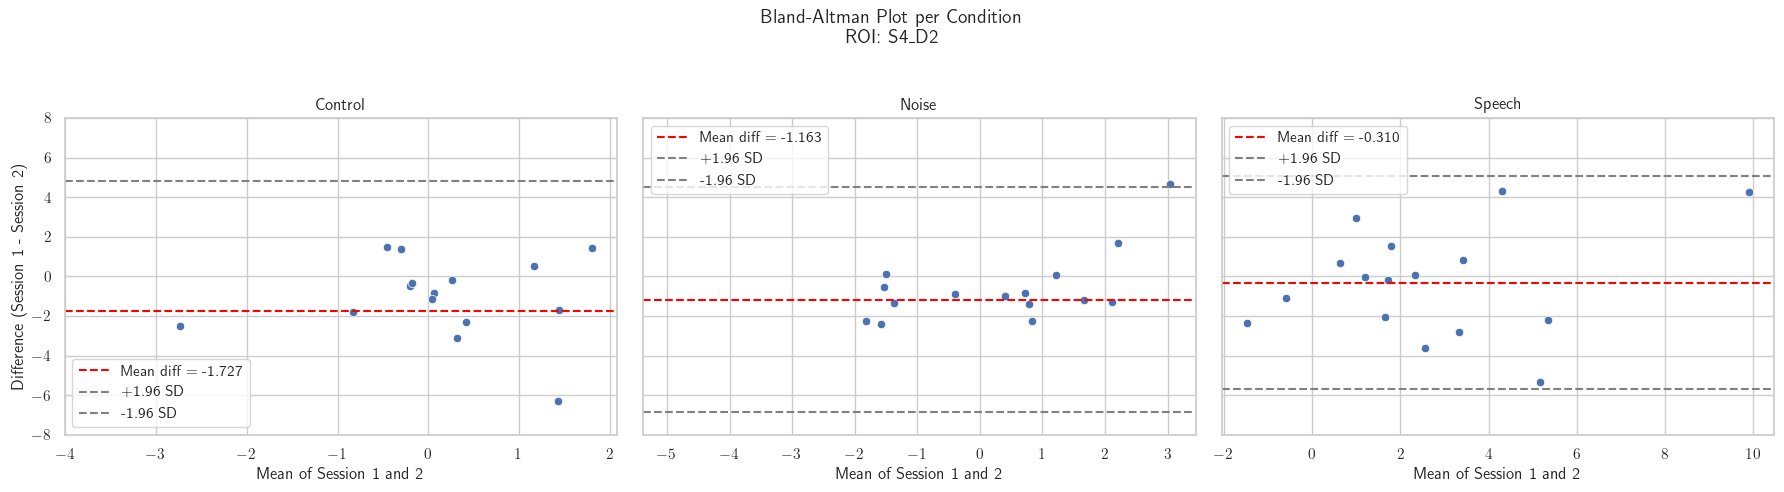

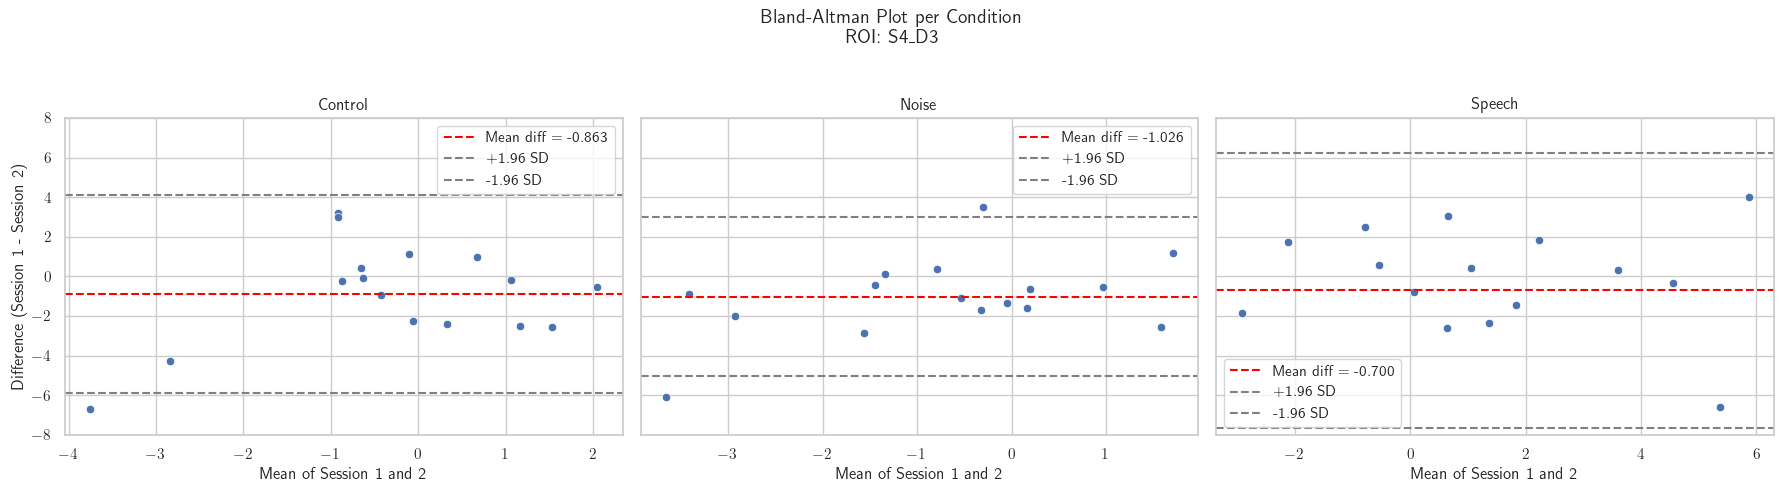

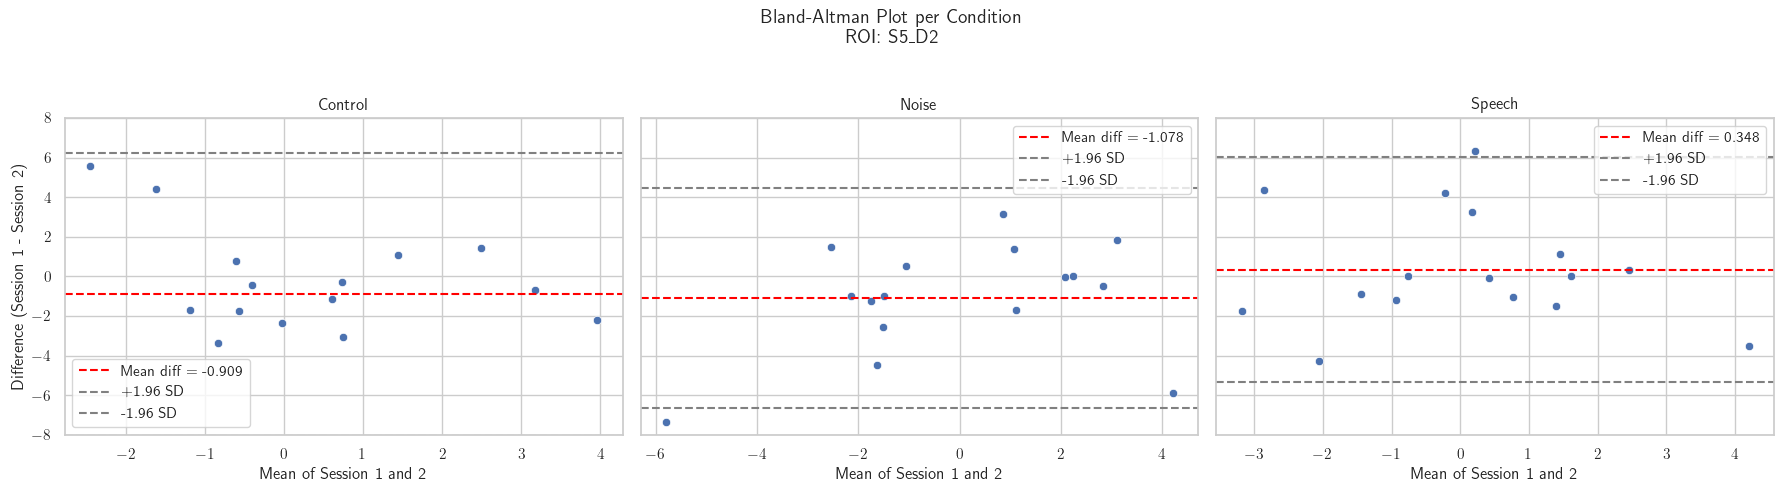

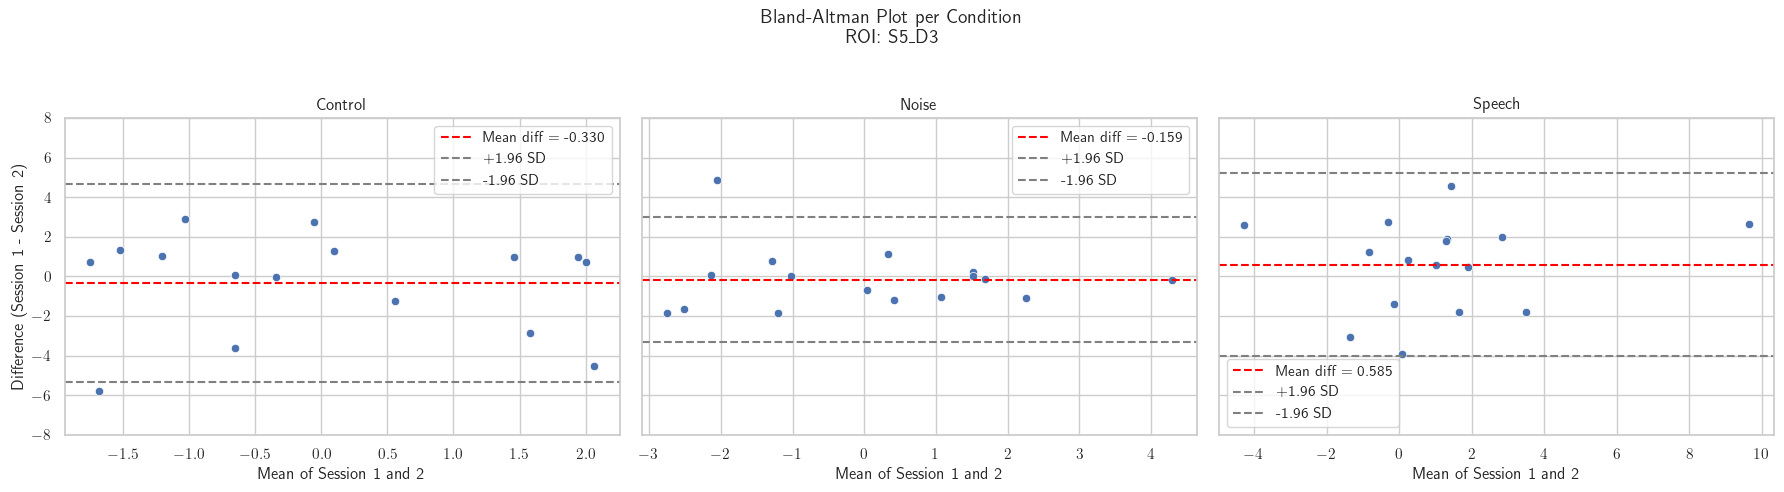

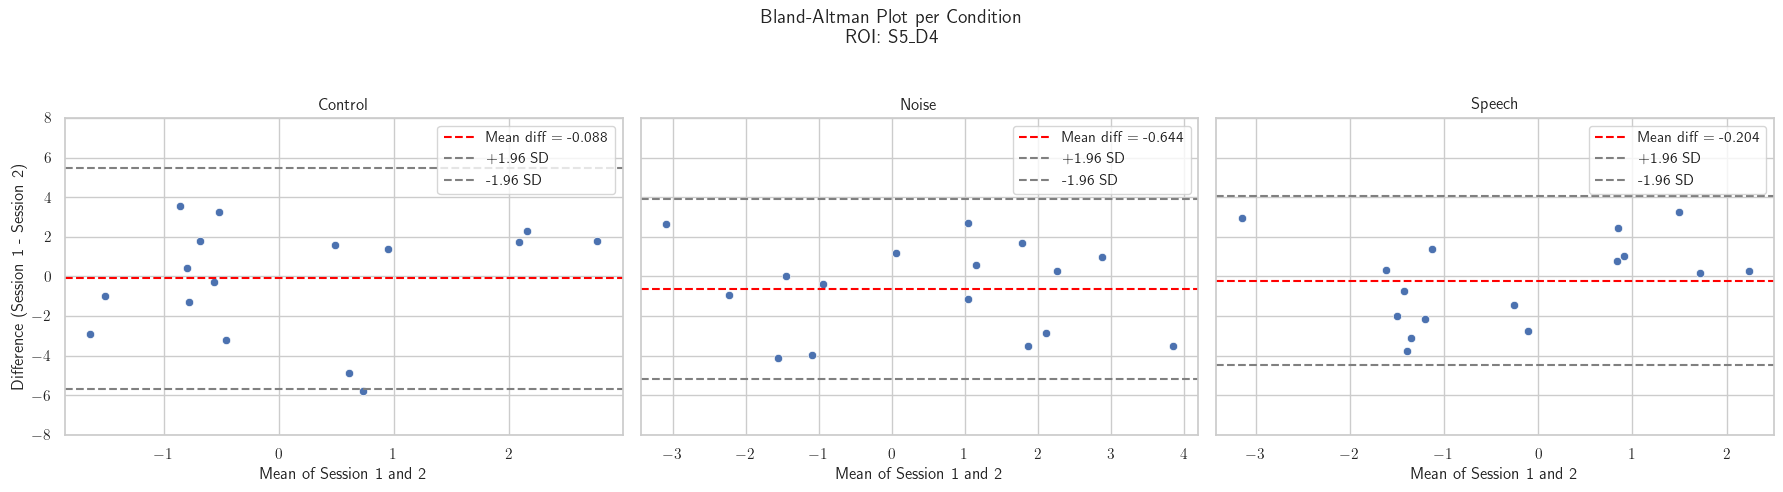

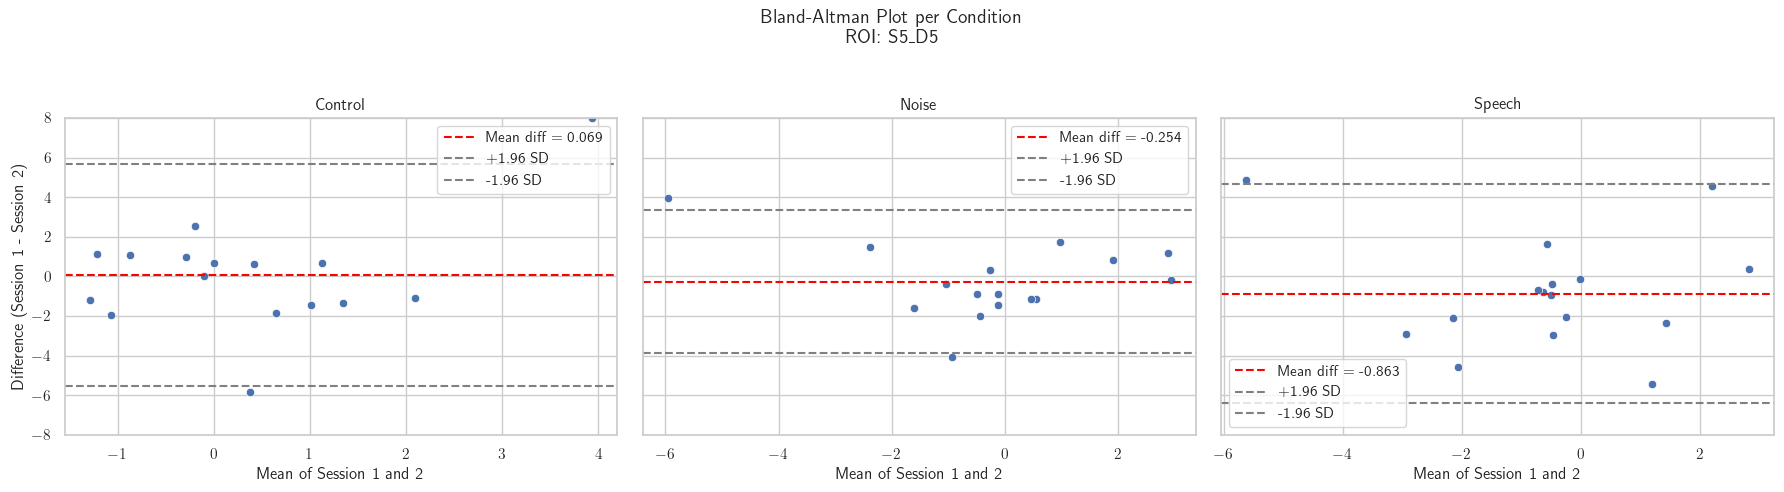

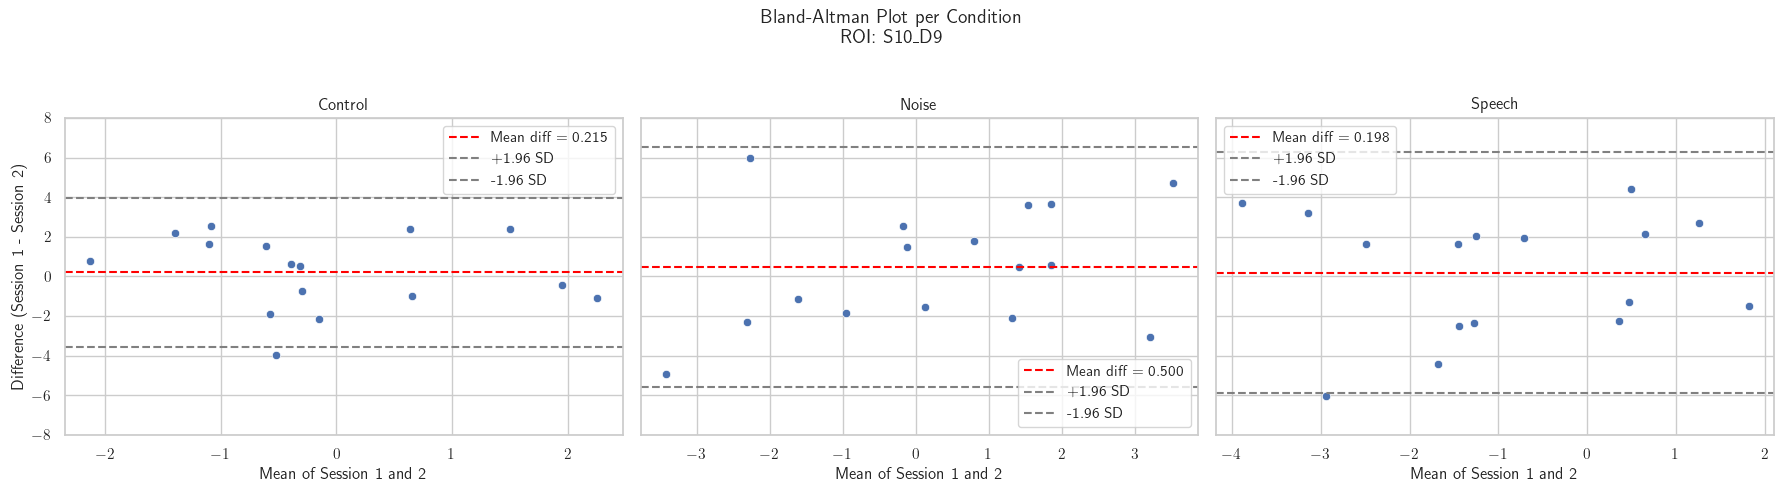

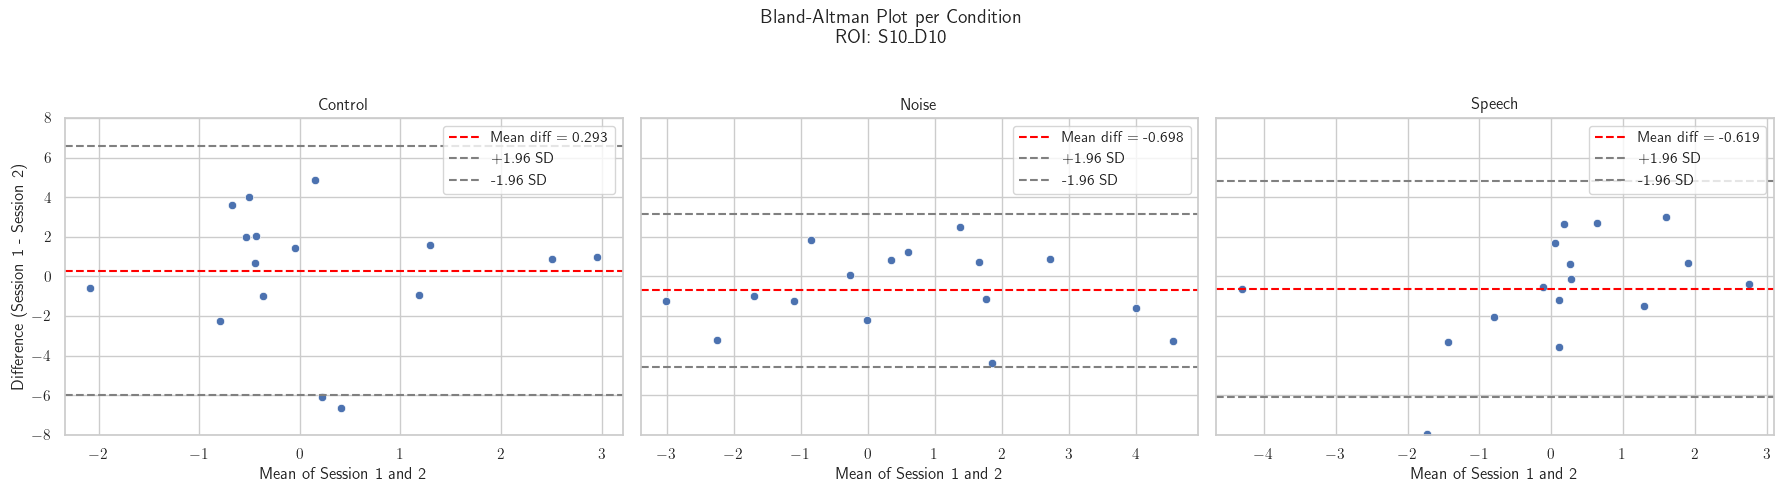

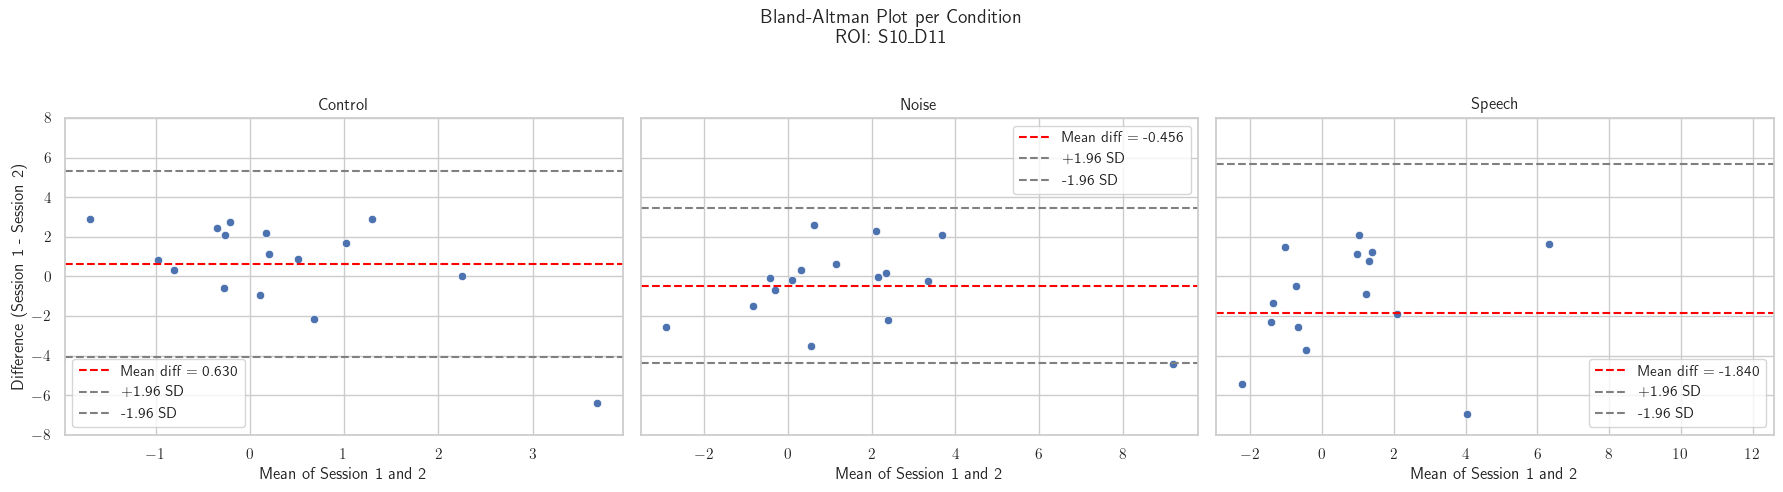

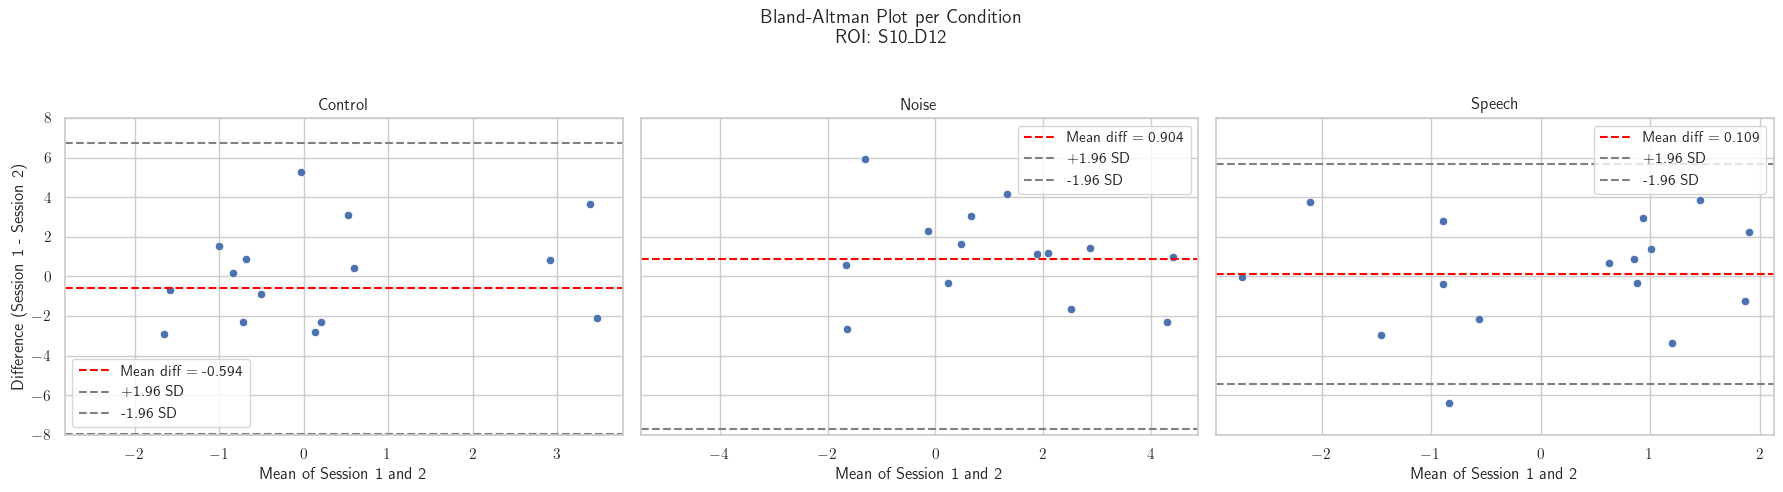

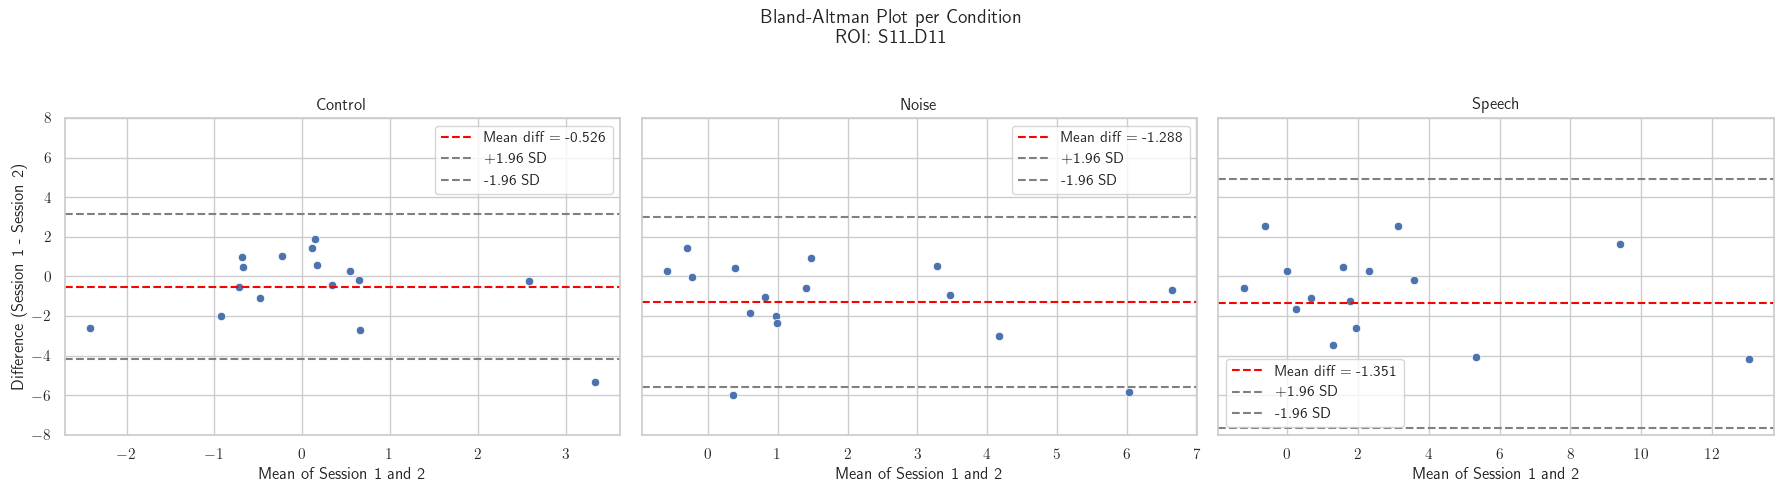

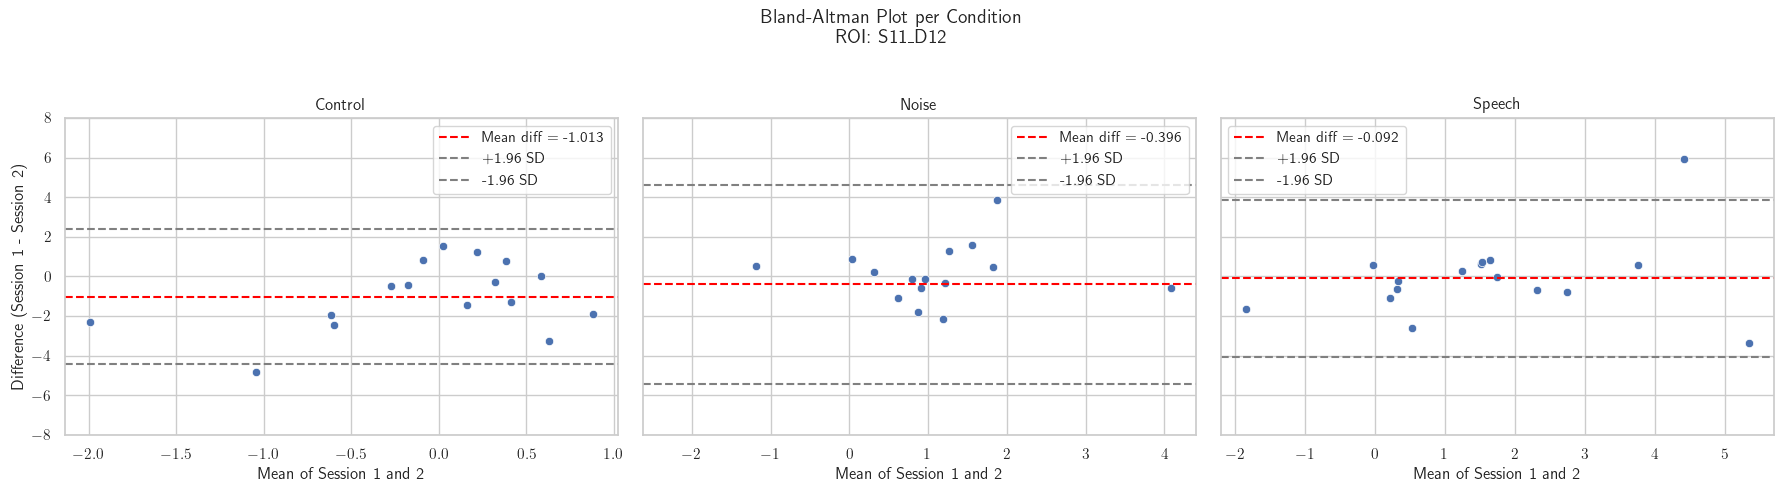

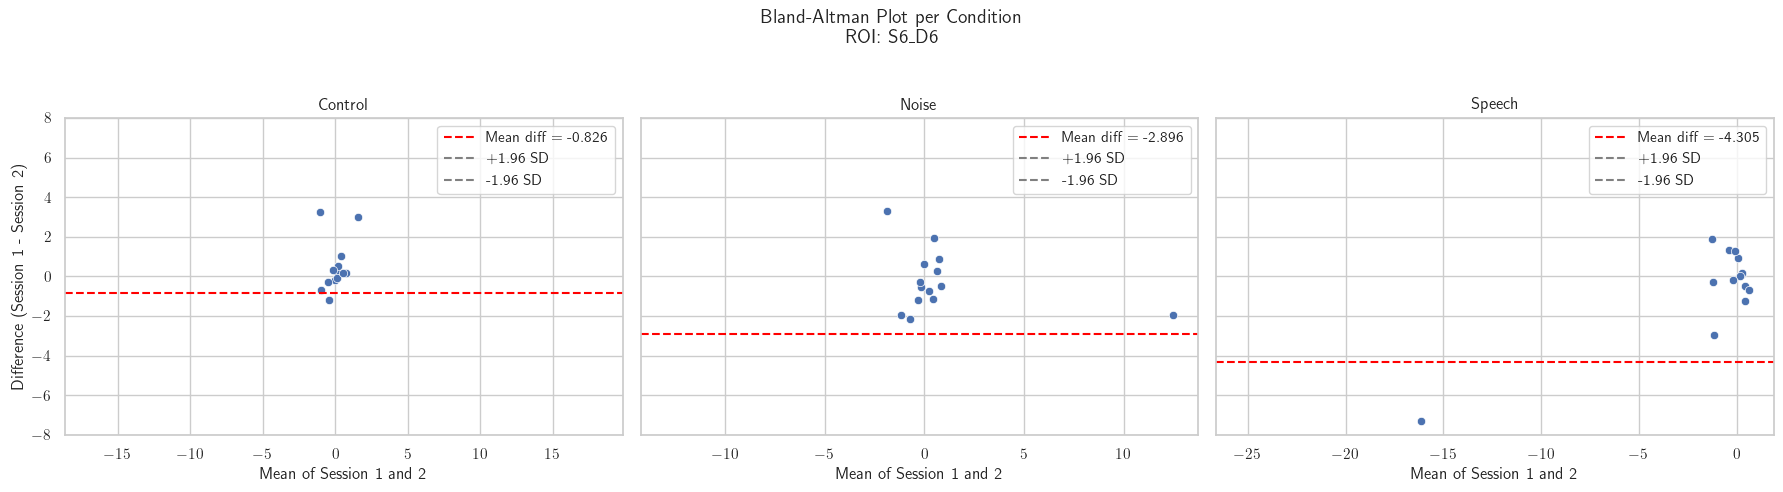

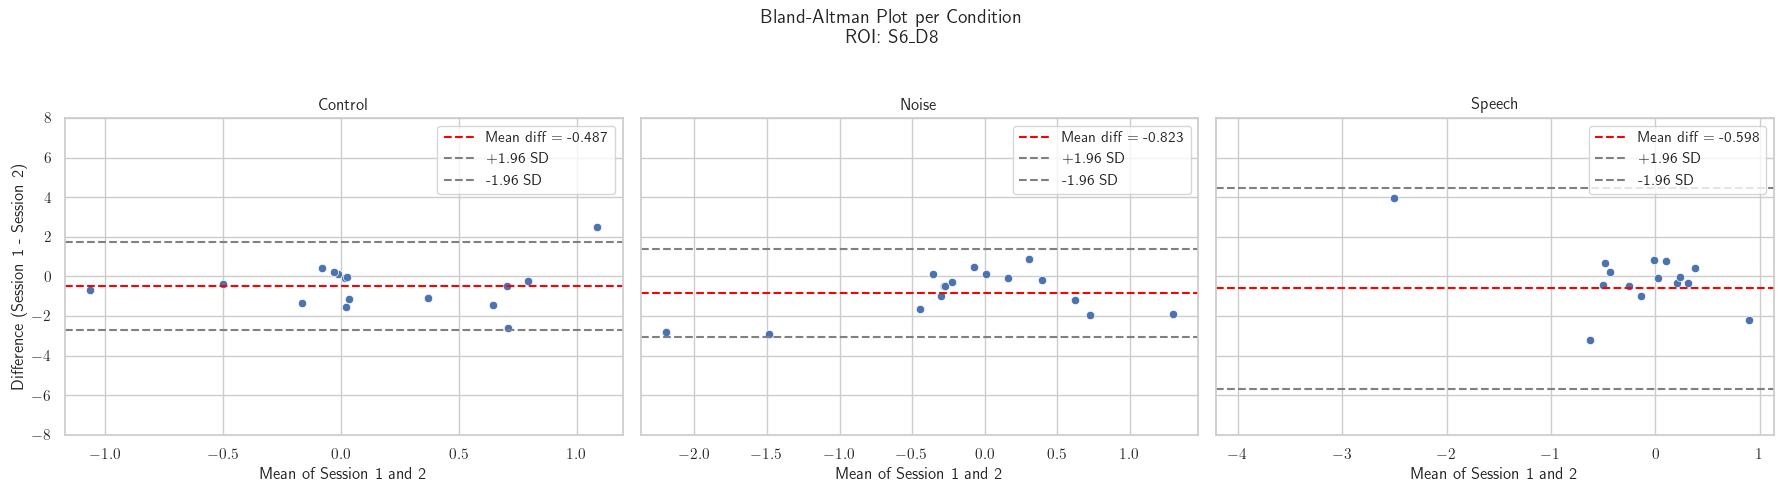

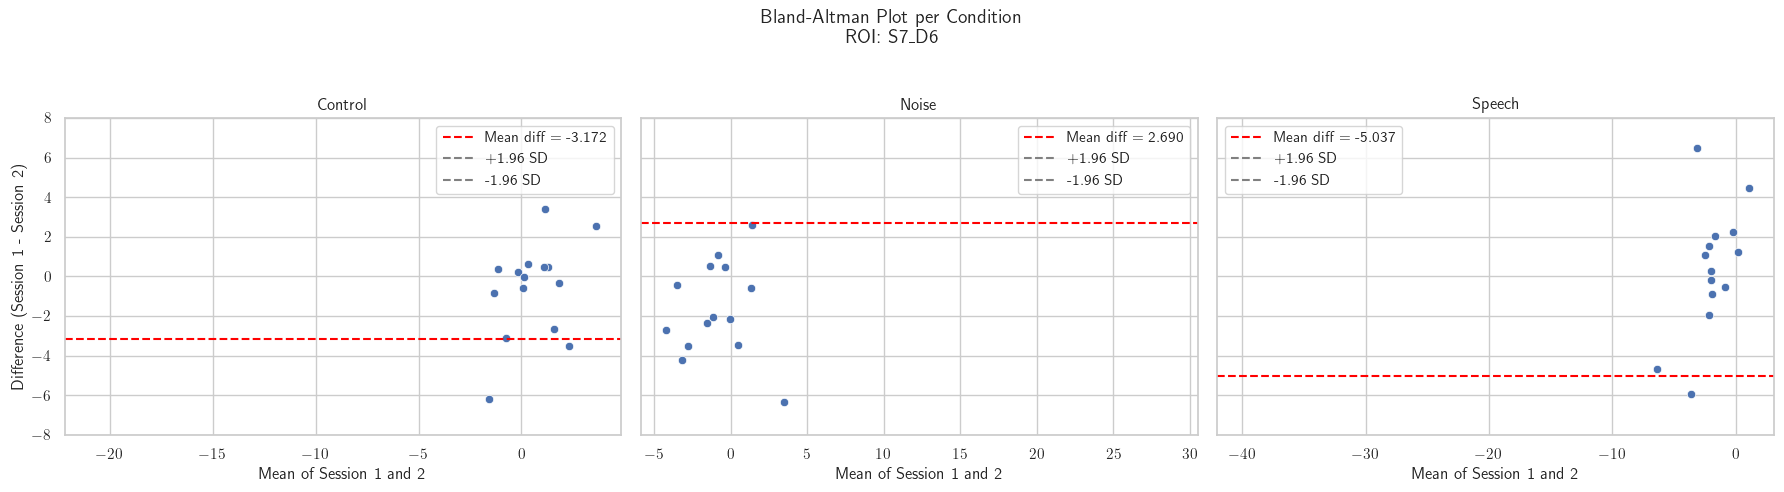

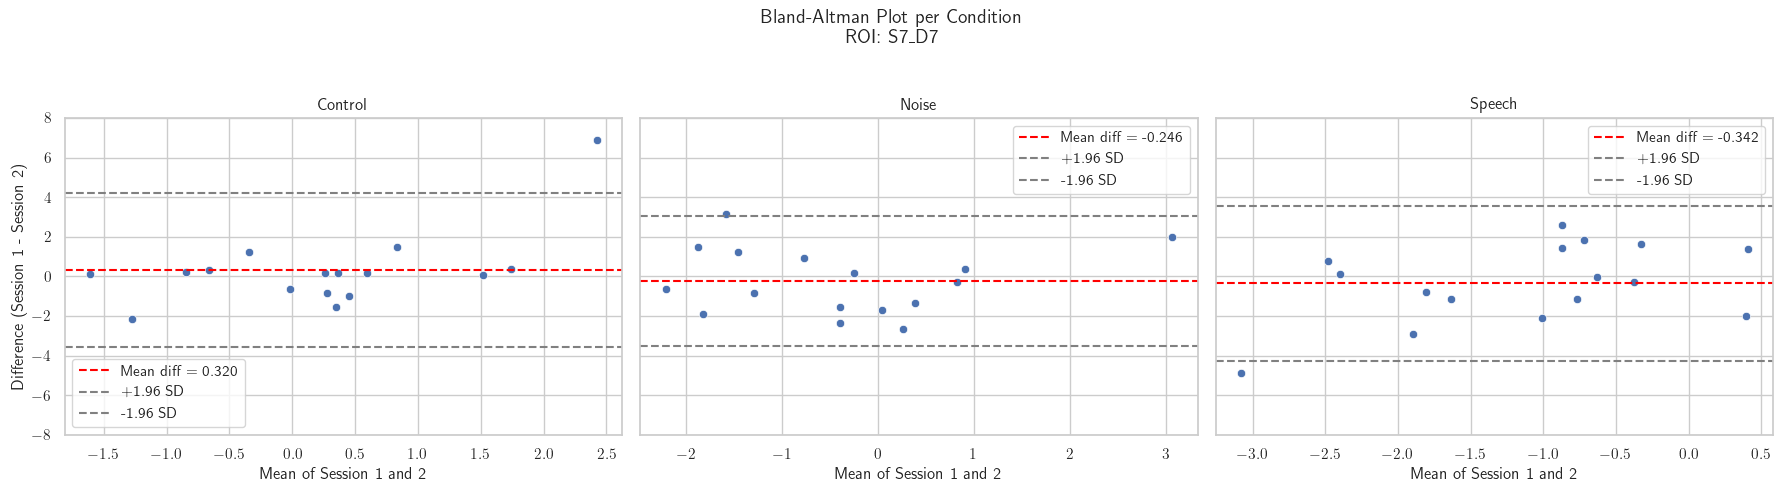

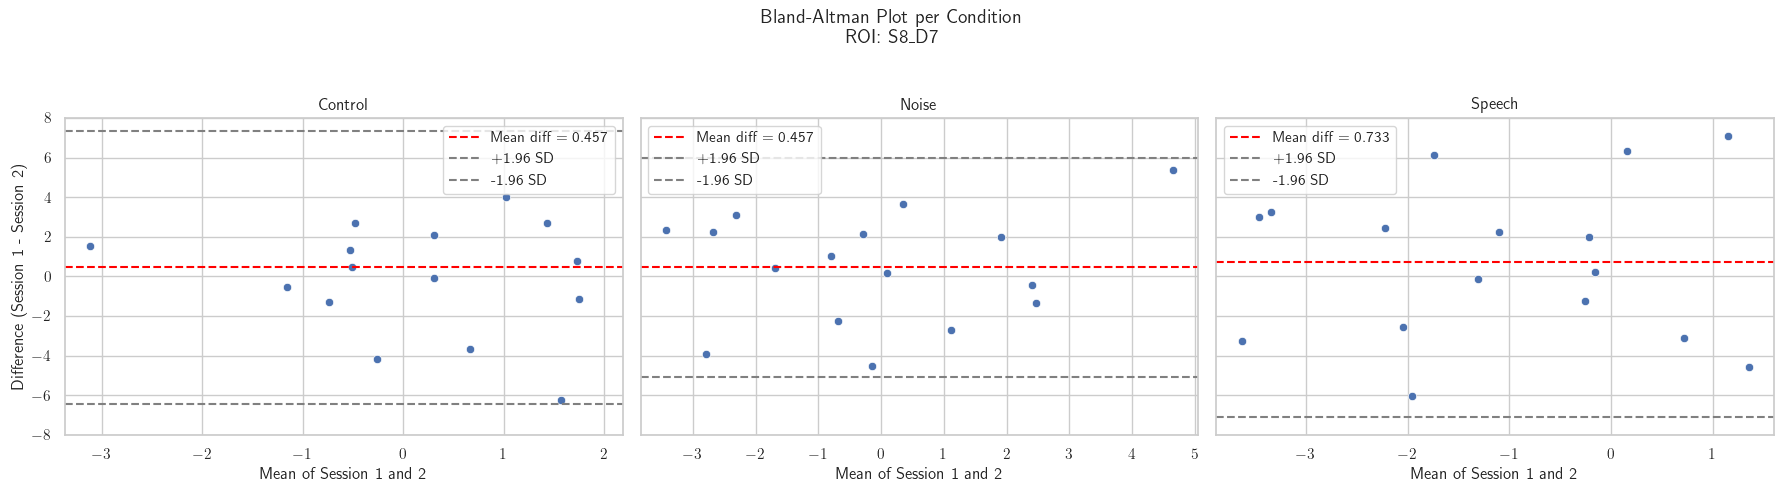

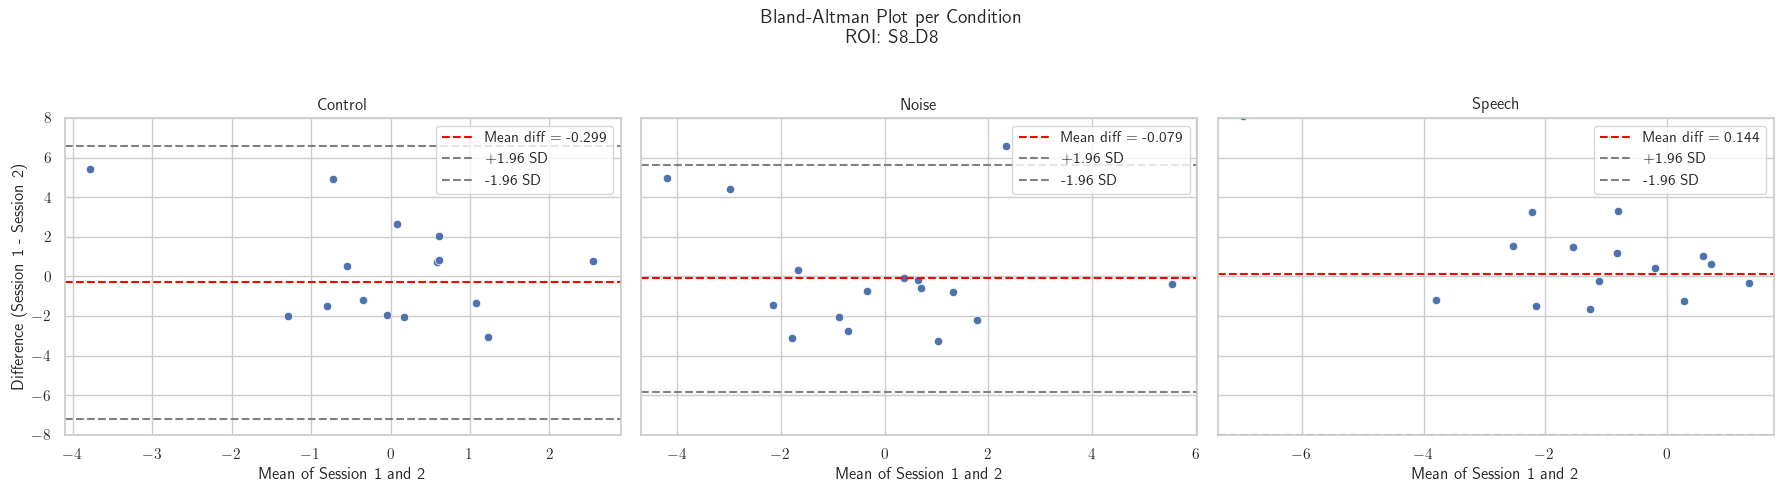

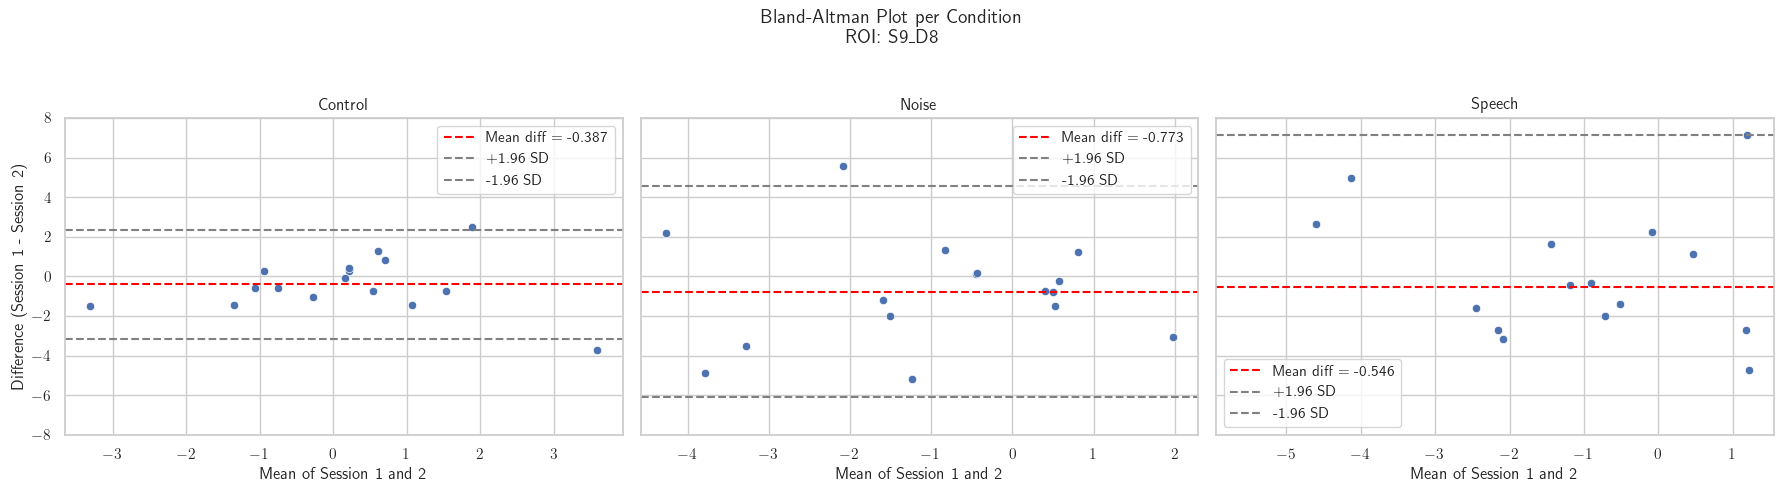

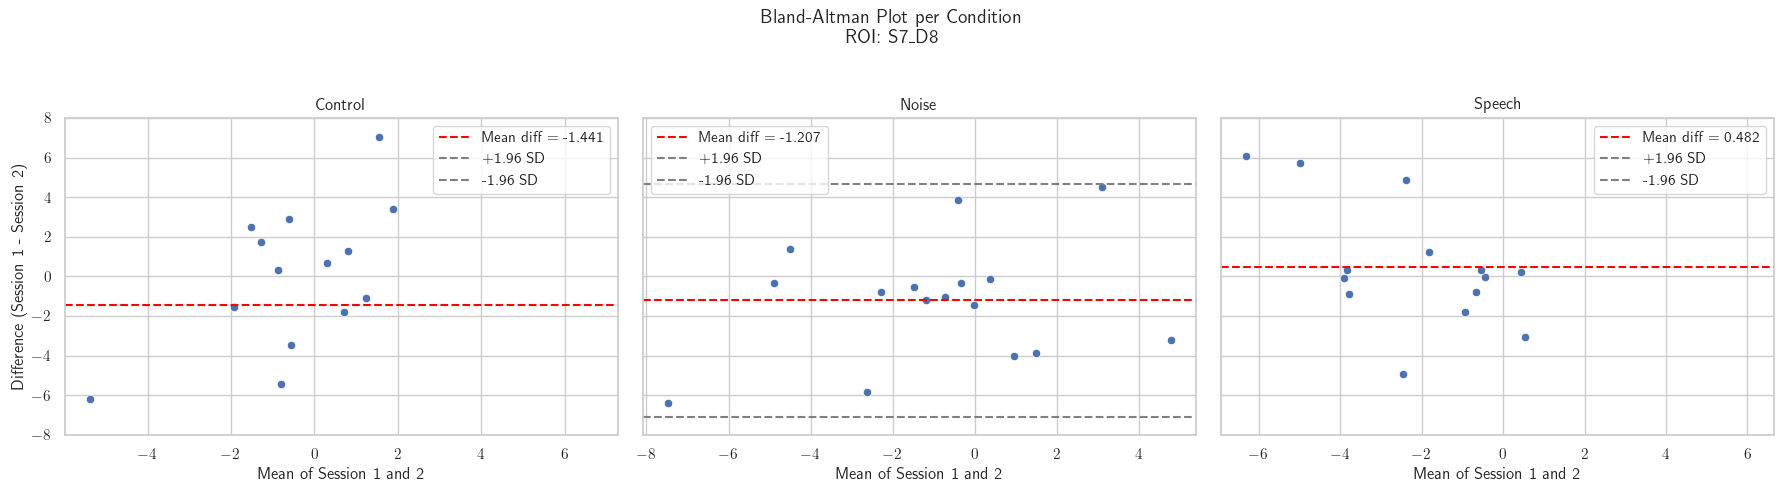

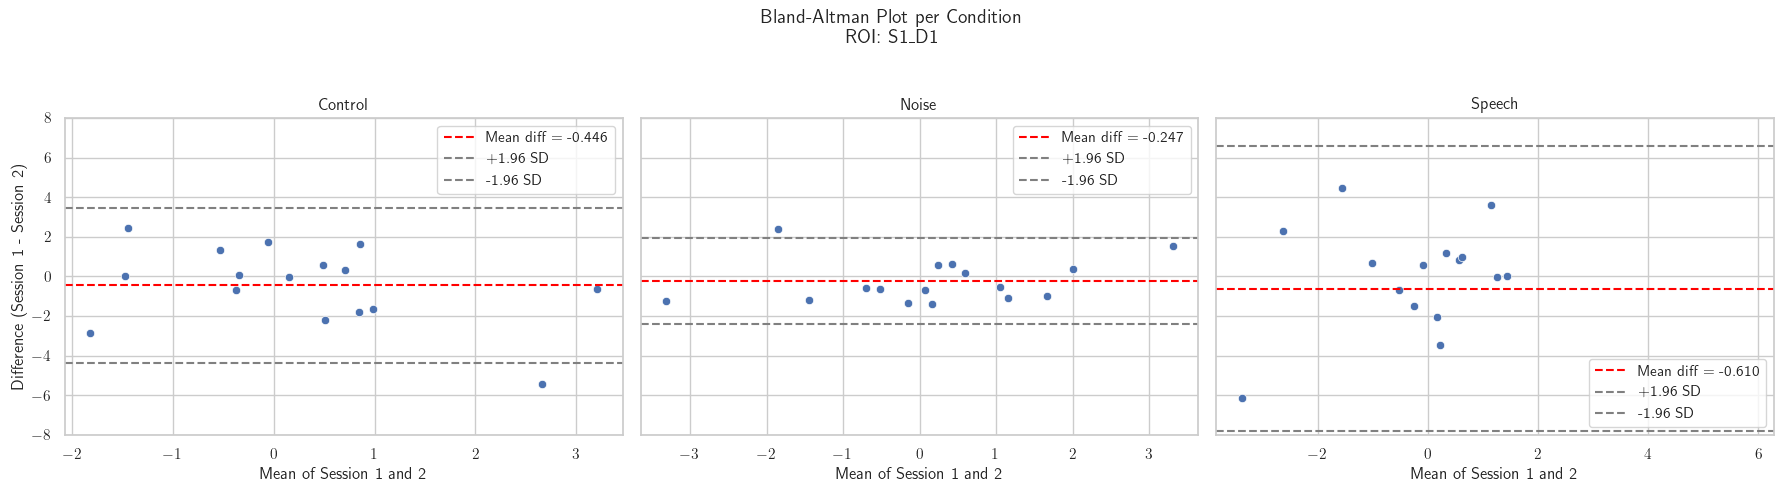

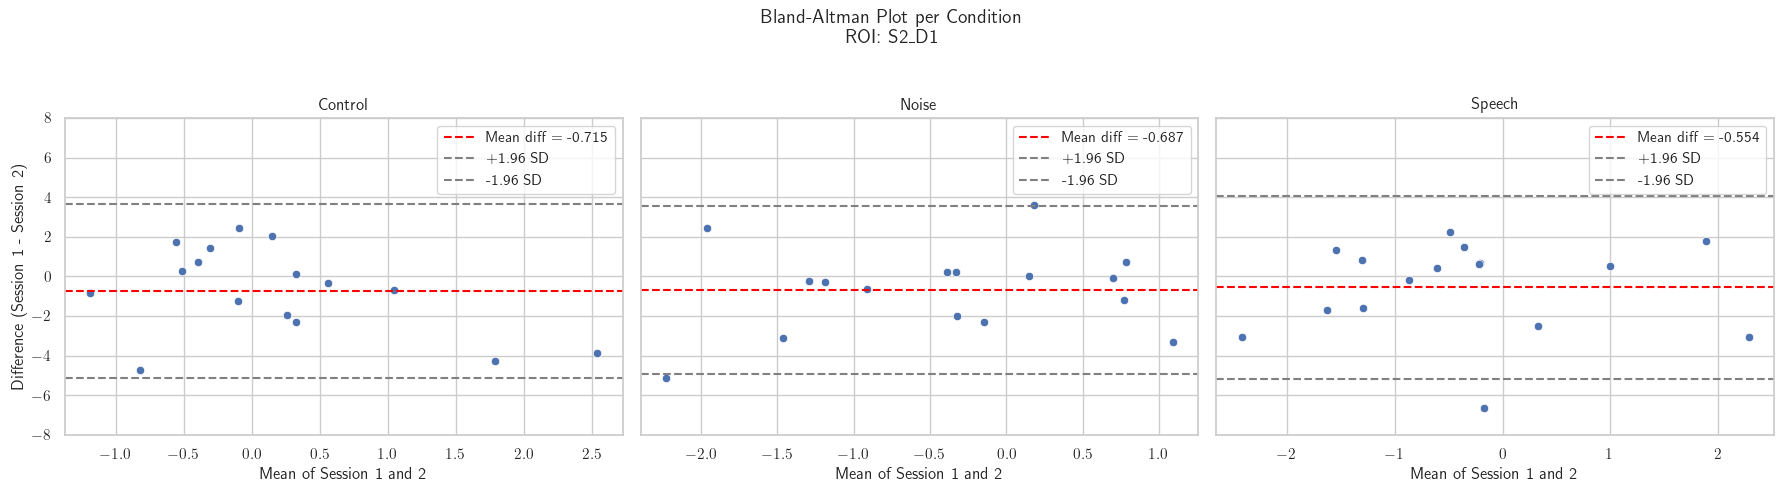

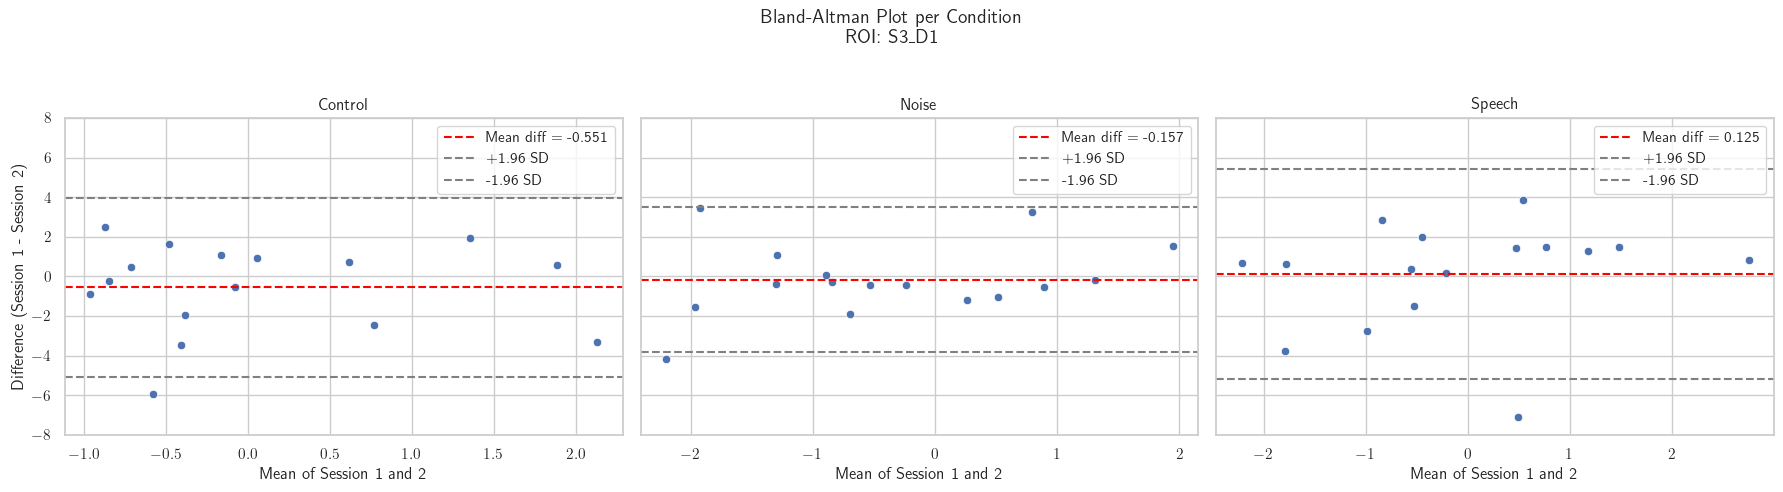

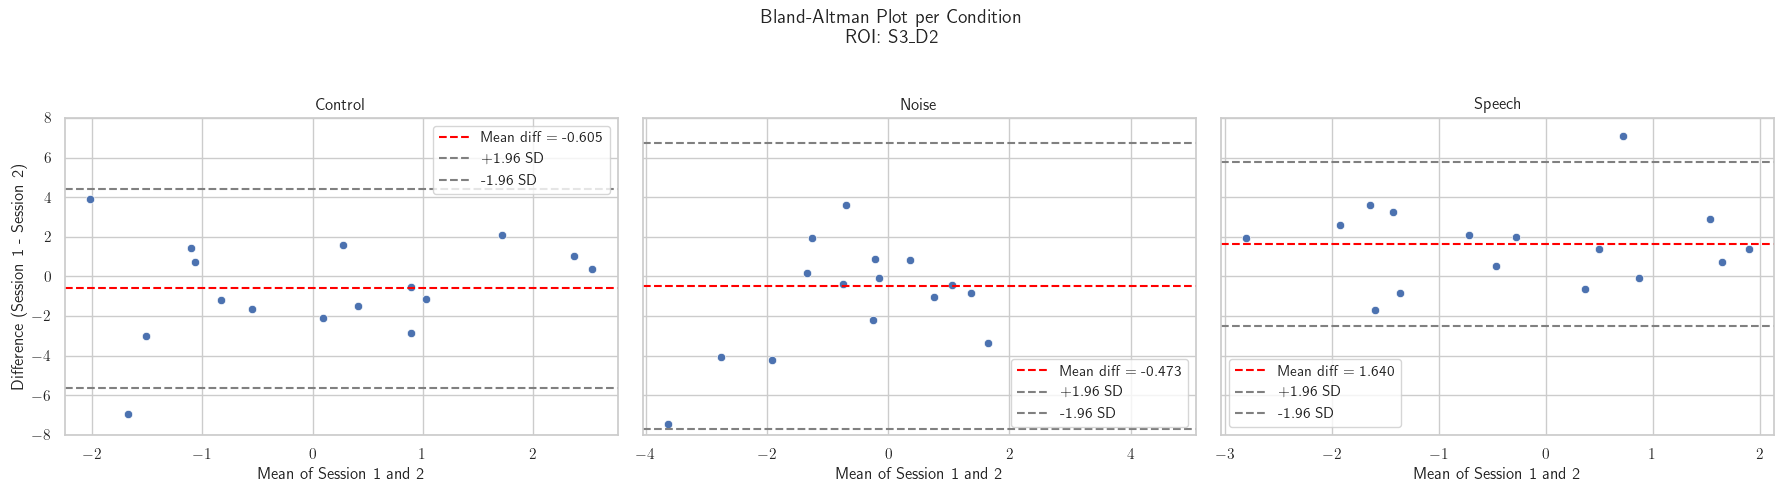

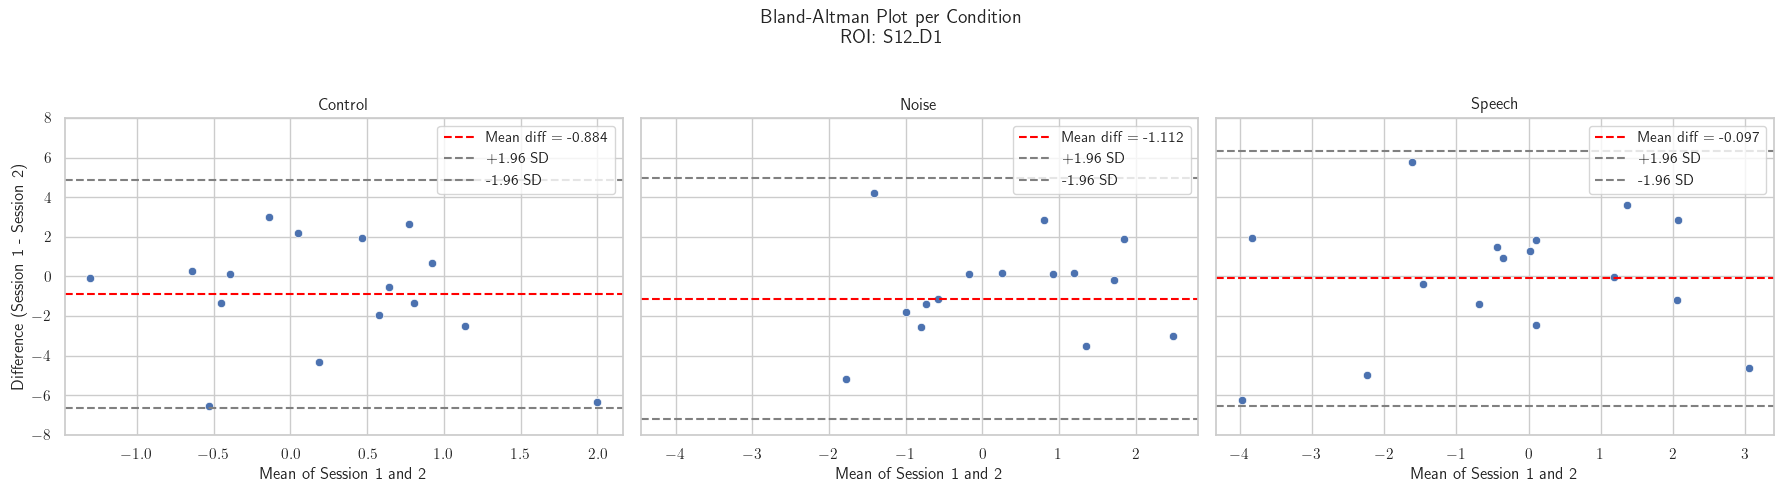

In [44]:
# Get unique experimental conditions
conditions = df_combined["Condition"].unique()
df_combined["session"] = df_combined["session"].astype(str).str.zfill(2)

# --- Bland-Altman plots per ROI and condition ---
for roi_name, optodes in rois.items():
    fig, axes = plt.subplots(1, len(conditions), figsize=(6 * len(conditions), 5), sharey=True)
    if len(conditions) == 1:
        axes = [axes]  # Ensure iterable if only one condition

    for ax, condition in zip(axes, conditions):
        # Filter data for current ROI and condition
        subset = df_combined[
            (df_combined["Optode"].isin(optodes)) & 
            (df_combined["Condition"] == condition)
        ]

        # Average over optodes for each subject and session
        mean_vals = subset.groupby(["Subject", "session"])["theta"].mean().reset_index()

        # Pivot so each subject has session 01 and 02 as columns
        pivot = mean_vals.pivot(index="Subject", columns="session", values="theta").dropna()

        if pivot.shape[0] < 2:
            ax.set_title(f'{condition}\nNot enough data')
            ax.axis('off')
            continue

        # Bland-Altman calculations
        session1 = pivot["01"]
        session2 = pivot["02"]
        avg = (session1 + session2) / 2
        diff = session1 - session2
        mean_diff = diff.mean()
        std_diff = diff.std()

        # Plot
        sns.scatterplot(x=avg, y=diff, ax=ax)
        ax.axhline(mean_diff, color='red', linestyle='--', label=f'Mean diff = {mean_diff:.3f}')
        ax.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
        ax.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
        ax.set_title(f'{condition}')
        ax.set_xlabel('Mean of Session 1 and 2')
        if ax == axes[0]:
            ax.set_ylabel('Difference (Session 1 - Session 2)')
            ax.set_ylim(-8, 8)
        else:
            ax.set_ylabel('')
        ax.legend()

    plt.suptitle(f'Bland-Altman Plot per Condition\nROI: {roi_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
